# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
!pip install PyDrive
!pip install keras==2.2.4
!pip install tensorflow==1.13.1
!pip install git+https://github.com/darecophoenixx/wordroid.sblo.jp

  Cloning https://github.com/darecophoenixx/wordroid.sblo.jp to /tmp/pip-req-build-ygdci6b0
  Running command git clone -q https://github.com/darecophoenixx/wordroid.sblo.jp /tmp/pip-req-build-ygdci6b0
  Created wheel for wordroid.sblo.jp: filename=wordroid.sblo.jp-0.0.1-cp36-none-any.whl size=33710 sha256=de4549e6a87d27eb3166f08c80c637a476c567e951239f19c5cdec1e4b9e91af
  Stored in directory: /tmp/pip-ephem-wheel-cache-1296p9gw/wheels/3d/6d/24/44e7d6dc47b39e74772a04beb27433ba2ebed90876394cda60
Successfully built wordroid.sblo.jp


In [2]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

#Set seeds
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,self.imsize)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.8)*diff + (-0.2)*euclidean(individual-self.img.reshape(1,self.imsize))/self.imsize 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(self.imsize)-self.img.reshape(self.imsize))
        individual = self.X_best.reshape(1,self.imsize)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"16oao6c9BTb33sbaFzCDJ1sGQn4Z0ILS7"}) 
downloaded.GetContentFile('rbfnn_v2.h5')   

num_lm0 = 100
num_lm = num_lm0 * 10
init_wgt = np.zeros(((1000, 784)))

inp = Input(shape=(28*28,), name='inp')
oup = GaussianKernel(num_lm, 28*28,
                     kernel_gamma='auto', weights=[init_wgt],
                     name='gkernel1')(inp)
oup = Dense(10, activation='softmax')(oup)
model = Model(inp, oup)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("rbfnn_v2.h5")

Instructions for updating:
Colocations handled automatically by placer.


# Prepare Data

In [0]:
import pickle
file_ = open('subset', 'rb')
dump = pickle.load(file_)
adversarial = pickle.load(file_)
dump = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()
del dump

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 20, #50 (5) #200 (1)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2) (it was 2000)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4) (it was 125)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  0.14943299458662607 25
50  :  0.14943299458662607 25
75  :  0.16851448270303498 25
100  :  0.14638986340150473 25
125  :  0.1273158240568925 25
150  :  0.15600077086221442 25
175  :  0.20474565585593485 25
200  :  0.22459905664877045 25
225  :  0.24276286255230695 25
250  :  0.2691978288621626 25
275  :  0.2691978288621626 25
300  :  0.2691978288621626 25
325  :  0.2691978288621626 25
350  :  0.27437708950859135 25
375  :  0.28534701338050406 25
400  :  0.296361628344493 25
425  :  0.2970753367059099 25
450  :  0.2970753367059099 25
475  :  0.3004972428015706 25
500  :  0.3066767326421287 25
525  :  0.30920584032323234 25
550  :  0.3117577512354546 25
575  :  0.3172328746818612 25
600  :  0.3263097750776316 25
625  :  0.3270517926840992 25
650  :  0.3270559568188714 25
675  :  0.3306694868079154 25
700  :  0.33744448918595443 25
725  :  0.3379069353243404 25
750  :  0.3381697469948092 25
775  :  0.3392778829115824 25
800  :  0.33990941410302383 25
825  :  0.34578675862131064 25


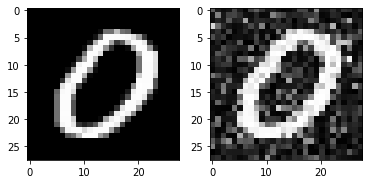

25  :  -0.13784998701601642 25
50  :  0.08808971070364469 25
75  :  0.1575362413531875 25
100  :  0.06217181842874708 25
125  :  0.09623341272373942 25
150  :  0.10802870601166314 25
175  :  0.17400090958545733 25
200  :  0.1887245048797478 25
225  :  0.2124461732201104 25
250  :  0.2124461732201104 25
275  :  0.2225241888044378 25
300  :  0.27558737799304306 25
325  :  0.27957432954837247 25
350  :  0.27957432954837247 25
375  :  0.28044481086628115 25
400  :  0.29346425986640773 25
425  :  0.2942264304540858 25
450  :  0.307335291942502 25
475  :  0.3098851869895676 25
500  :  0.3119438422188502 25
525  :  0.3168564686038464 25
550  :  0.3168564686038464 25
575  :  0.3188686943040692 25
600  :  0.32135866193134205 25
625  :  0.322113657230553 25
650  :  0.3237914526716794 25
675  :  0.32626121029437755 25
700  :  0.32656325594993574 25
725  :  0.32898195113028245 25
750  :  0.3324949229289262 25
775  :  0.3344627834200277 25
800  :  0.33619164001276924 25
825  :  0.337916078385064 25

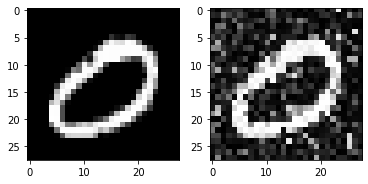

25  :  -0.13183830888954662 25
50  :  0.045920667702463724 25
75  :  -0.0025697264040348 25
100  :  0.036258486755716635 25
125  :  0.009457666215446303 25
150  :  0.07230811526896419 25
175  :  0.06553469268197121 25
200  :  0.10870363037570985 25
225  :  0.15048372573666813 25
250  :  0.15975299725564307 25
275  :  0.17403908410300717 25
300  :  0.17911233251714131 25
325  :  0.18760489530792157 25
350  :  0.18866508720858244 25
375  :  0.201541786150908 25
400  :  0.201541786150908 25
425  :  0.21116945220200678 25
450  :  0.21440937305102392 25
475  :  0.21440937305102392 25
500  :  0.21814264716418652 25
525  :  0.21848662818751297 25
550  :  0.22396291735075058 25
575  :  0.22812274792667575 25
600  :  0.23179321504264983 25
625  :  0.23793031958449795 25
650  :  0.23924841077627468 25
675  :  0.24186416194953597 25
700  :  0.2458656574291218 25
725  :  0.24588732773541366 25
750  :  0.24588732773541366 25
775  :  0.25042644858254437 25
800  :  0.25213247883751644 25
825  :  0.26

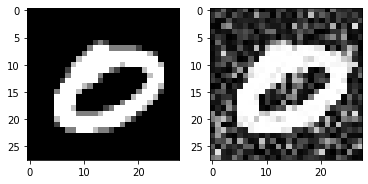

25  :  -0.7600694455997286 25
50  :  0.022388460537258403 25
75  :  -0.12519218475281213 25
100  :  -0.705349677676431 25
125  :  -0.8665830453615857 25
150  :  -0.8665830453615857 25
175  :  -0.4068334344684343 25
200  :  -0.8596288161761774 25
225  :  -0.84627500189461 25
250  :  -0.32002646608302565 25
275  :  -0.10367785814603225 25
300  :  -0.22493235430526756 25
325  :  0.25885976906324243 25
350  :  0.27015353531920977 25
375  :  0.27415753019885447 25
400  :  0.2896720210999548 25
425  :  0.30475863104317785 25
450  :  0.3082409357590369 25
475  :  0.31317286478035294 25
500  :  0.32606974219125967 25
525  :  0.33674290851090904 25
550  :  0.33636405882671805 25
575  :  0.3379562857190744 25
600  :  0.3386187348167569 25
625  :  0.3389945607023964 25
650  :  0.3440835335147881 25
675  :  0.34899962333249906 25
700  :  0.35112313279947216 25
725  :  0.3535171274048603 25
750  :  0.3567490410322651 25
775  :  0.3597620944597648 25
800  :  0.36197935727296515 25
825  :  0.36566354

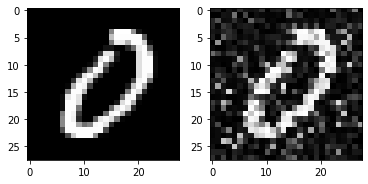

25  :  0.3460984592220217 25
50  :  0.3460984592220217 25
75  :  0.31275585439388875 25
100  :  0.3029131123941514 25
125  :  0.2728003157511029 25
150  :  0.33899440101168654 25
175  :  0.33899440101168654 25
200  :  0.3604483911164949 25
225  :  0.3760539069205534 25
250  :  0.3827625361976104 25
275  :  0.3868498106026145 25
300  :  0.39050708981947274 25
325  :  0.3930786770216137 25
350  :  0.39628727990557394 25
375  :  0.39628727990557394 25
400  :  0.407696723650056 25
425  :  0.41021330053208144 25
450  :  0.41021330053208144 25
475  :  0.41271415709258014 25
500  :  0.4126978951784159 25
525  :  0.413368752409965 25
550  :  0.4147512189532914 25
575  :  0.41699831159126044 25
600  :  0.4178488804755292 25
625  :  0.4225613835776637 25
650  :  0.4226137733183258 25
675  :  0.42960204797886287 25
700  :  0.4295903862120323 25
725  :  0.4295903862120323 25
750  :  0.4337075257989274 25
775  :  0.4336630296404807 25
800  :  0.43572339912238 25
825  :  0.43572339912238 25
850  :  

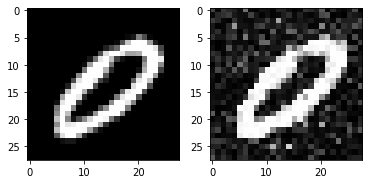

25  :  0.21188062610699687 25
50  :  0.32485217612879236 25
75  :  0.2967627198990841 25
100  :  0.30867258469826103 25
125  :  0.3378461371507097 25
150  :  0.3365648390200441 25
175  :  0.4147053913708934 25
200  :  0.41493316100272976 25
225  :  0.41493316100272976 25
250  :  0.41493316100272976 25
275  :  0.4298676533720326 25
300  :  0.43026183671114004 25
325  :  0.43026183671114004 25
350  :  0.4309675754913428 25
375  :  0.4362023943870072 25
400  :  0.4501465661513941 25
425  :  0.4503880420533105 25
450  :  0.4550461926838471 25
475  :  0.45502997424197494 25
500  :  0.45502997424197494 25
525  :  0.4608990145422462 25
550  :  0.4627349426291745 25
575  :  0.46271840177608015 25
600  :  0.46271840177608015 25
625  :  0.46271840177608015 25
650  :  0.46535465088744943 25
675  :  0.4656415715538501 25
700  :  0.4656415715538501 25
725  :  0.4656415715538501 25
750  :  0.4661649445765941 25
775  :  0.46696652616266093 25
800  :  0.4682844235713154 25
825  :  0.46828806904742554 

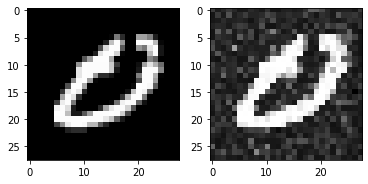

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


25  :  -0.6946017536804439 25
50  :  -0.21390912486526015 25
75  :  -0.6060102842867995 25
100  :  -0.8868823589572368 25
125  :  -0.8847407694465452 25
150  :  -0.8811235013203642 25
175  :  -0.8767459424605508 25
200  :  -0.872653371663483 25
225  :  -0.872486142655043 25
250  :  -0.872403337864347 25
275  :  -0.8708304384354341 25
300  :  -0.8666982772080877 25
325  :  -0.8666848477920036 25
350  :  -0.8666848477920036 25
375  :  -0.8666848477920036 25
400  :  -0.8666848477920036 25
425  :  -0.8666848477920036 25
450  :  -0.8658934997248465 25
475  :  -0.8653173328905988 25
500  :  -0.8633385052928406 25
525  :  -0.8633350106659674 25
550  :  -0.8630264687910121 25
575  :  -0.8619492950069867 25
600  :  -0.8615384084715227 25
625  :  -0.8604854097242817 25
650  :  -0.860484943250252 25
675  :  -0.8599090128280809 25
700  :  -0.8593692073310161 25
725  :  -0.8593692073310161 25
750  :  -0.8593692073310161 25
775  :  -0.8593183659460933 25
800  :  -0.8591773919912138 25
825  :  -0.859

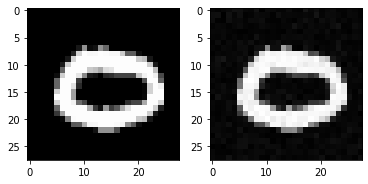

25  :  -0.7870945153550952 25
50  :  -0.3215280449646015 25
75  :  -0.887121881193238 25
100  :  -0.8806508061123219 25
125  :  -0.8803055086488764 25
150  :  -0.8780393601518119 25
175  :  -0.8778426469977779 25
200  :  -0.5330689717036966 25
225  :  -0.874596972346144 25
250  :  -0.8745264181603448 25
275  :  -0.8745264181603448 25
300  :  -0.873178662977407 25
325  :  -0.8731428893489009 25
350  :  -0.8688059862160422 25
375  :  -0.8682164356586399 25
400  :  -0.8682164356586399 25
425  :  -0.8675109446970211 25
450  :  -0.8648173525475011 25
475  :  -0.8648173525475011 25
500  :  -0.8631204533841874 25
525  :  -0.8631204533841874 25
550  :  -0.8631204533841874 25
575  :  -0.86295101820396 25
600  :  -0.8624672291034393 25
625  :  -0.8624670075991199 25
650  :  -0.8624670075991199 25
675  :  -0.8619475526941424 25
700  :  -0.861343393212564 25
725  :  -0.861343393212564 25
750  :  -0.8611616017724018 25
775  :  -0.8611186325831437 25
800  :  -0.8611186325831437 25
825  :  -0.8611186

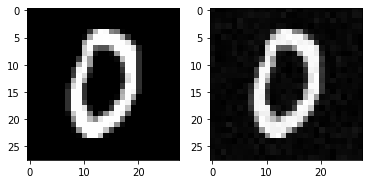

25  :  -0.6423546391369673 25
50  :  -0.13288018094353427 25
75  :  -0.12100235210602273 25
100  :  0.08891339926849506 25
125  :  0.11329686215041379 25
150  :  0.17947247832718605 25
175  :  0.1988682959633971 25
200  :  0.1988682959633971 25
225  :  0.27158451765577796 25
250  :  0.29497863809232383 25
275  :  0.29167537401951954 25
300  :  0.2969903993950874 25
325  :  0.33187444747336 25
350  :  0.34890558727774146 25
375  :  0.3513763134674005 25
400  :  0.36058483388003265 25
425  :  0.36058483388003265 25
450  :  0.3729281171339627 25
475  :  0.3729281171339627 25
500  :  0.3805361525204487 25
525  :  0.38126439489579433 25
550  :  0.38220354958637853 25
575  :  0.38767736327494096 25
600  :  0.3938245374581693 25
625  :  0.39566395131664533 25
650  :  0.405306691425869 25
675  :  0.4054577818771635 25
700  :  0.4055862347342787 25
725  :  0.4105591770614141 25
750  :  0.4108981248870709 25
775  :  0.4134142425567026 25
800  :  0.4143609786983322 25
825  :  0.4165279856535674 2

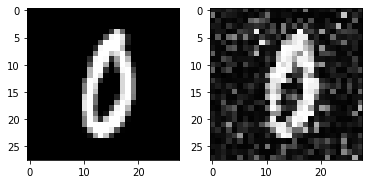

25  :  -0.6329573960698288 25
50  :  -0.07810689834583429 25
75  :  -0.6851734312375315 25
100  :  -0.514430026320521 25
125  :  -0.8836062859929745 25
150  :  -0.8823592210548225 25
175  :  -0.8821053797307016 25
200  :  -0.8821053797307016 25
225  :  -0.8802789398358688 25
250  :  -0.878903459068226 25
275  :  -0.8753821501040361 25
300  :  -0.8729553289605778 25
325  :  -0.8729553289605778 25
350  :  -0.8729553289605778 25
375  :  -0.8729553289605778 25
400  :  -0.8729553289605778 25
425  :  -0.8726263591241538 25
450  :  -0.8726088614342379 25
475  :  -0.8726088614342379 25
500  :  -0.8722219224053105 25
525  :  -0.8711568938525406 25
550  :  -0.8684339189129814 25
575  :  -0.8684339189129814 25
600  :  -0.8684339189129814 25
625  :  -0.8684339189129814 25
650  :  -0.8684339189129814 25
675  :  -0.8684339189129814 25
700  :  -0.8666732703238905 25
725  :  -0.866677139745343 25
750  :  -0.865944709268724 25
775  :  -0.8657775881121555 25
800  :  -0.8655364100394654 25
825  :  -0.865

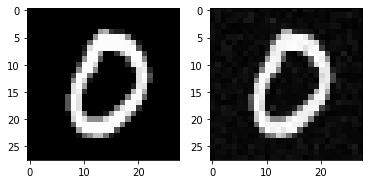

25  :  0.5546735416270909 25
50  :  0.5546735416270909 25
75  :  0.5547844396704247 25
100  :  0.5548427576054817 25
125  :  0.5604359331412739 25
150  :  0.568523283158396 25
175  :  0.568523283158396 25
200  :  0.5748250580087895 25
225  :  0.5734842962791458 25
250  :  0.5739748007894596 25
275  :  0.5744716104911758 25
300  :  0.5843692725539148 25
325  :  0.5859489946749968 25
350  :  0.5874792348801791 25
375  :  0.5958123309530814 25
400  :  0.5967076935501157 25
425  :  0.5989634834675652 25
450  :  0.5989699274976448 25
475  :  0.5998256857190678 25
500  :  0.6022187173395331 25
525  :  0.6055625833678278 25
550  :  0.6067268096075323 25
575  :  0.6066974501865254 25
600  :  0.6087637335359635 25
625  :  0.6108035855286424 25
650  :  0.6108140081229744 25
675  :  0.6127610867698545 25
700  :  0.6138514654033613 25
725  :  0.6138982761303877 25
750  :  0.6141314583719468 25
775  :  0.6151828419052794 25
800  :  0.6151827942302138 25
Time:  87.71875762939453  seconds
Predicted c

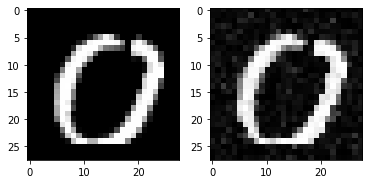

25  :  -0.3662162025445319 25
50  :  -0.19385400898101518 25
75  :  -0.36527217922198796 25
100  :  -0.8885146790717651 25
125  :  -0.8885146790717651 25
150  :  -0.8885146790717651 25
175  :  -0.8878627354671019 25
200  :  -0.8842027201409289 25
225  :  -0.8811598600057333 25
250  :  -0.8796453201890804 25
275  :  -0.8796263243157149 25
300  :  -0.8728573683796557 25
325  :  -0.8728573683796557 25
350  :  -0.8728573683796557 25
375  :  -0.8728573683796557 25
400  :  -0.8728573683796557 25
425  :  -0.8693265401436769 25
450  :  -0.8693265401436769 25
475  :  -0.8693265401436769 25
500  :  -0.8677912122655868 25
525  :  -0.8662292377408989 25
550  :  -0.8662292377408989 25
575  :  -0.8662292377408989 25
600  :  -0.8639615073096516 25
625  :  -0.8628042473640658 25
650  :  -0.8628042473640658 25
675  :  -0.8624935032775704 25
700  :  -0.8624931251800062 25
725  :  -0.8622572002149496 25
750  :  -0.8618748649784407 25
775  :  -0.8617845614101102 25
800  :  -0.8606900190699781 25
825  :  -

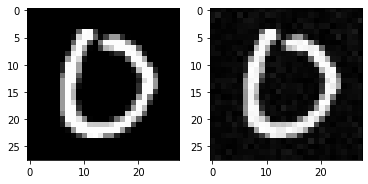

25  :  0.6480657228347153 25
50  :  0.6525123148605156 25
75  :  0.6521652103420887 25
100  :  0.6523660690674551 25
125  :  0.6538825048878678 25
150  :  0.6558003117956372 25
175  :  0.6545719439979322 25
200  :  0.6545719439979322 25
225  :  0.6560267835071518 25
250  :  0.6617423659472017 25
275  :  0.6617423659472017 25
300  :  0.6617423659472017 25
325  :  0.6617423659472017 25
350  :  0.6636507442044195 25
375  :  0.6639312599836114 25
400  :  0.6646186223053716 25
425  :  0.6647033616612772 25
450  :  0.665955202670167 25
475  :  0.6658580427334257 25
500  :  0.6715425521252659 25
525  :  0.6715425521252659 25
550  :  0.6715425521252659 25
575  :  0.6720127774617439 25
600  :  0.6720298692560792 25
625  :  0.6720298692560792 25
650  :  0.6735777529237323 25
675  :  0.6739960566837576 25
700  :  0.6745027316750868 25
725  :  0.6768132193438522 25
750  :  0.6768835631853994 25
775  :  0.6770409050439515 25
800  :  0.6770409050439515 25
Time:  112.82445311546326  seconds
Predicted

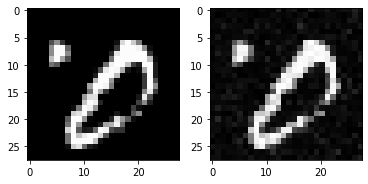

25  :  -0.7702824800403121 25
50  :  -0.5391685880976302 25
75  :  -0.11301555233280332 25
100  :  0.30933898974833 25
125  :  0.37645505108545413 25
150  :  0.38254968586339044 25
175  :  0.43280521254487875 25
200  :  0.4372047364378786 25
225  :  0.44882264983862075 25
250  :  0.4486265413930525 25
275  :  0.4501820292337173 25
300  :  0.4529296393341748 25
325  :  0.46521155006372356 25
350  :  0.4700505688024349 25
375  :  0.4708760332449799 25
400  :  0.47903408501204175 25
425  :  0.47976532219665546 25
450  :  0.48232999985992864 25
475  :  0.4851116589284956 25
500  :  0.48569077741383504 25
525  :  0.49020772148592834 25
550  :  0.49118666228886576 25
575  :  0.49171639101259557 25
600  :  0.49415112253286686 25
625  :  0.4956247074124245 25
650  :  0.4962848387102918 25
675  :  0.500232627594015 25
700  :  0.5002332487287138 25
725  :  0.5008960345008685 25
750  :  0.5019181573387832 25
775  :  0.5019181573387832 25
800  :  0.501988376254451 25
825  :  0.502220862280375 25
8

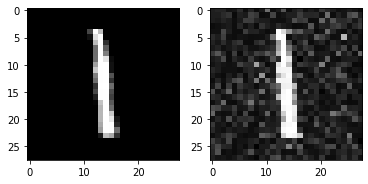

25  :  -0.8723901551414116 25
50  :  -0.8359374015901342 25
75  :  -0.8670383717948094 25
100  :  -0.8670383717948094 25
125  :  -0.8670383717948094 25
150  :  -0.864828524597225 25
175  :  -0.8626883640305768 25
200  :  -0.857791683235884 25
225  :  -0.8574658753820062 25
250  :  -0.8574658753820062 25
275  :  -0.8574658753820062 25
300  :  -0.8574658753820062 25
325  :  -0.8566191690483865 25
350  :  -0.8565667106239023 25
375  :  -0.8544817908407123 25
400  :  -0.8534352071843061 25
425  :  -0.8471279397359349 25
450  :  -0.839762220064291 25
475  :  -0.8280258189330085 25
500  :  -0.7940274254258172 25
525  :  -0.7899807996545665 25
550  :  -0.7104797081839123 25
575  :  -0.3828171468447896 25
600  :  0.021203324107815225 25
625  :  0.17094644190799863 25
650  :  0.2188521371597658 25
675  :  0.21870678510564528 25
700  :  0.21870678510564528 25
725  :  0.27697992766690577 25
750  :  0.3001139811365124 25
775  :  0.3116636842389103 25
800  :  0.3173725981865725 25
825  :  0.3499078

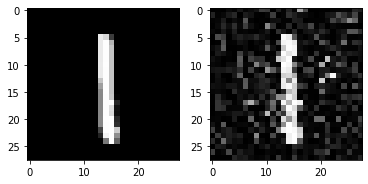

25  :  -0.8016717565948045 25
50  :  -0.6873831303363475 25
75  :  -0.7132096179891004 25
100  :  -0.5552700351612837 25
125  :  -0.36266621936247717 25
150  :  0.2642297104826189 25
175  :  0.40352976966796256 25
200  :  0.42635694301385996 25
225  :  0.42635694301385996 25
250  :  0.4333462557374937 25
275  :  0.44773006136625876 25
300  :  0.45011549409918905 25
325  :  0.45011549409918905 25
350  :  0.4609255264835823 25
375  :  0.4654548548053206 25
400  :  0.4654548548053206 25
425  :  0.4709297080743639 25
450  :  0.47060307394667206 25
475  :  0.47060307394667206 25
500  :  0.47387580873841967 25
525  :  0.475669052672337 25
550  :  0.48160664738851444 25
575  :  0.48259558666880875 25
600  :  0.4856546266708094 25
625  :  0.4902499527302968 25
650  :  0.49065295706495177 25
675  :  0.49256318006584743 25
700  :  0.4944635615250783 25
725  :  0.4947831210047079 25
750  :  0.4957172217399972 25
775  :  0.49762824441030323 25
800  :  0.4985677620180595 25
825  :  0.49931961383364

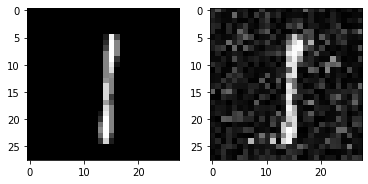

25  :  -0.8898541421051509 25
50  :  -0.8898541421051509 25
75  :  -0.8893897351533872 25
100  :  -0.877751118598707 25
125  :  -0.877751118598707 25
150  :  -0.877751118598707 25
175  :  -0.877751118598707 25
200  :  -0.8751057021540884 25
225  :  -0.8732362778455257 25
250  :  -0.8690600803337135 25
275  :  -0.8690600803337135 25
300  :  -0.8690600803337135 25
325  :  -0.8683264858316909 25
350  :  -0.8671752843429344 25
375  :  -0.8662308605456495 25
400  :  -0.8662308605456495 25
425  :  -0.8653699017488764 25
450  :  -0.8653681797868312 25
475  :  -0.8653681797868312 25
500  :  -0.8653681797868312 25
525  :  -0.865004866252458 25
550  :  -0.8644108492799351 25
575  :  -0.8644025895806365 25
600  :  -0.8641593394401791 25
625  :  -0.8641595041621397 25
650  :  -0.8641595041621397 25
675  :  -0.8639424945726377 25
700  :  -0.863559101842942 25
725  :  -0.863559101842942 25
750  :  -0.863184662414314 25
775  :  -0.863184662414314 25
800  :  -0.8629273922996196 25
825  :  -0.862927392

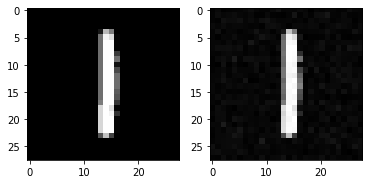

25  :  -0.5232664567054299 25
50  :  -0.5055201612130911 25
75  :  -0.4502549993178348 25
100  :  -0.267342793568116 25
125  :  -0.04392541101894756 25
150  :  0.3053167310052848 25
175  :  0.4682327997045417 25
200  :  0.4812165696554511 25
225  :  0.4936158696037013 25
250  :  0.49664894096245443 25
275  :  0.5056043630769331 25
300  :  0.5132740799805086 25
325  :  0.5178507813539001 25
350  :  0.5178507813539001 25
375  :  0.5281895550353725 25
400  :  0.528861044161536 25
425  :  0.5453326686094278 25
450  :  0.5453326686094278 25
475  :  0.5453326686094278 25
500  :  0.5453326686094278 25
525  :  0.5453326686094278 25
550  :  0.5476755020888866 25
575  :  0.5478787320697036 25
600  :  0.5489139463850258 25
625  :  0.5500673375249197 25
650  :  0.5500673375249197 25
675  :  0.5511528511002735 25
700  :  0.5521315029730947 25
725  :  0.5523120033350936 25
750  :  0.5525758197756292 25
775  :  0.5528152091754716 25
800  :  0.5536134883924435 25
825  :  0.5549633211700701 25
850  :  

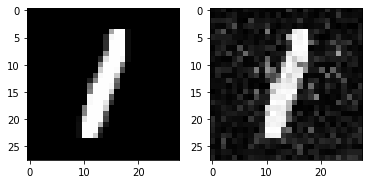

25  :  -0.45120559510847535 25
50  :  -0.11348771561101761 25
75  :  0.1629641798973495 25
100  :  0.31434721813915656 25
125  :  0.37957161655614824 25
150  :  0.41591985503152007 25
175  :  0.43127292441208254 25
200  :  0.44101567208176207 25
225  :  0.47836396238927453 25
250  :  0.48126479656345866 25
275  :  0.48819599334194774 25
300  :  0.48833771880033516 25
325  :  0.49822927726335053 25
350  :  0.5058474773889444 25
375  :  0.5178179946730501 25
400  :  0.5180249353088675 25
425  :  0.527331736136261 25
450  :  0.5308286222485279 25
475  :  0.531993030037949 25
500  :  0.5323784895717135 25
525  :  0.5345758067285202 25
550  :  0.5397951468497914 25
575  :  0.5397951468497914 25
600  :  0.5397951468497914 25
625  :  0.5413119122853919 25
650  :  0.5442618287042578 25
675  :  0.5442710479444174 25
700  :  0.5482468304619241 25
725  :  0.5522624018221058 25
750  :  0.5522742745013824 25
775  :  0.5544161511333532 25
800  :  0.5548968825315967 25
825  :  0.5548968825315967 25
8

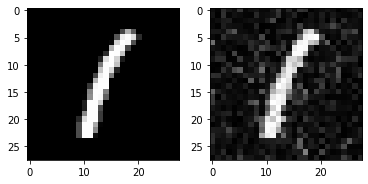

25  :  0.30609967969724905 25
50  :  0.3903512838723212 25
75  :  0.3037186736025691 25
100  :  0.46123101228493046 25
125  :  0.48399844599183584 25
150  :  0.4761663952557408 25
175  :  0.5311956925729804 25
200  :  0.5356535954913926 25
225  :  0.5741517553979828 25
250  :  0.5611535050424958 25
275  :  0.5611535050424958 25
300  :  0.5611535050424958 25
325  :  0.5611535050424958 25
350  :  0.5611535050424958 25
375  :  0.5614081472600351 25
400  :  0.5637585844246088 25
425  :  0.5637585844246088 25
450  :  0.571979115999331 25
475  :  0.5802819094776425 25
500  :  0.5802819094776425 25
525  :  0.5846087939149718 25
550  :  0.5865561628020997 25
575  :  0.5870781917536206 25
600  :  0.5916244121150644 25
625  :  0.594036941681246 25
650  :  0.5951649120031499 25
675  :  0.5957396038345774 25
700  :  0.5964229333886149 25
725  :  0.5990206122795986 25
750  :  0.6021376985382286 25
775  :  0.6036936628316124 25
800  :  0.6039654942953312 25
825  :  0.6071455798333477 25
850  :  0.60

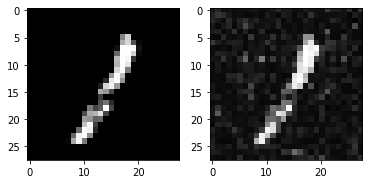

25  :  -0.22258038580882616 25
50  :  0.27612344556045404 25
75  :  0.3397177327876169 25
100  :  0.3195168690829974 25
125  :  0.3329930201179132 25
150  :  0.37238407140013124 25
175  :  0.3786167665226179 25
200  :  0.3924978554893107 25
225  :  0.40026554527723945 25
250  :  0.41328603791759033 25
275  :  0.4208705869482101 25
300  :  0.41893170562384074 25
325  :  0.41955966408919126 25
350  :  0.42227600999717857 25
375  :  0.42198264767815735 25
400  :  0.42783285746844535 25
425  :  0.4310024826285414 25
450  :  0.4337054510008405 25
475  :  0.43508660589898474 25
500  :  0.43496941641416004 25
525  :  0.4383942869825547 25
550  :  0.4426951000486105 25
575  :  0.4424853030618462 25
600  :  0.447458664666415 25
625  :  0.4479309505617194 25
650  :  0.45228074073470087 25
675  :  0.45228074073470087 25
700  :  0.45228074073470087 25
725  :  0.45228074073470087 25
750  :  0.4529182331101455 25
775  :  0.4536280834271184 25
800  :  0.45375443634900703 25
825  :  0.4548689293638367

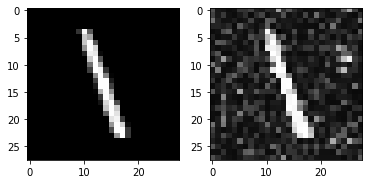

25  :  -0.816077683752256 25
50  :  -0.7601343589114087 25
75  :  -0.733076628736004 25
100  :  -0.5333274129671363 25
125  :  -0.027413375605351897 25
150  :  0.1581673624933735 25
175  :  0.2539439372954538 25
200  :  0.3519765883375745 25
225  :  0.3707688417421987 25
250  :  0.38628233554906305 25
275  :  0.3888193526844694 25
300  :  0.4205541721684565 25
325  :  0.4643264380660426 25
350  :  0.46524807350216024 25
375  :  0.46950290427192304 25
400  :  0.4818140304196709 25
425  :  0.4817368299573461 25
450  :  0.48710091483674445 25
475  :  0.48711258516104733 25
500  :  0.491105443955809 25
525  :  0.491105443955809 25
550  :  0.49776843243776253 25
575  :  0.5057473789445128 25
600  :  0.5059837078972982 25
625  :  0.5059837078972982 25
650  :  0.5069901841709341 25
675  :  0.5127188792642743 25
700  :  0.5127188792642743 25
725  :  0.5128468931331023 25
750  :  0.5140911340155611 25
775  :  0.514786677639693 25
800  :  0.5181665582778534 25
825  :  0.5204865276572733 25
850  

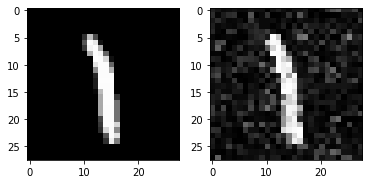

25  :  -0.8815998284234997 25
50  :  -0.8810953503322702 25
75  :  -0.8792728256485248 25
100  :  -0.8791678272080348 25
125  :  -0.8736890679375782 25
150  :  -0.8733816070679017 25
175  :  -0.8728194061438518 25
200  :  -0.8711641330503114 25
225  :  -0.8695560695353584 25
250  :  -0.8683181278518188 25
275  :  -0.8674442738105113 25
300  :  -0.8662462684321965 25
325  :  -0.8661902948105302 25
350  :  -0.8652762212953646 25
375  :  -0.8652762212953646 25
400  :  -0.8644885475956404 25
425  :  -0.8637249023692193 25
450  :  -0.8624732185615207 25
475  :  -0.8620292328927611 25
500  :  -0.862029312269611 25
525  :  -0.8619740289878638 25
550  :  -0.8616938679412948 25
575  :  -0.861364931968002 25
600  :  -0.8605386511615146 25
625  :  -0.860535981457356 25
650  :  -0.8604262354632007 25
675  :  -0.8604262354115755 25
700  :  -0.8604015961727918 25
725  :  -0.8599831461231404 25
750  :  -0.8599324102633752 25
775  :  -0.8597954830056014 25
800  :  -0.8594649666133379 25
Time:  76.8149

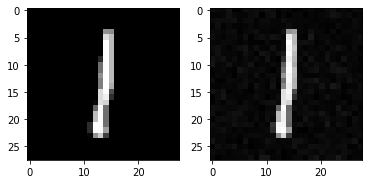

25  :  -0.8811573570037853 25
50  :  -0.8798108222395755 25
75  :  -0.8705176423231709 25
100  :  -0.8705176423231709 25
125  :  -0.8690612447428837 25
150  :  -0.8660358992910848 25
175  :  -0.8521780119874505 25
200  :  -0.8397066173714104 25
225  :  -0.8217344582684747 25
250  :  -0.6402072247896102 25
275  :  -0.0577006610342764 25
300  :  0.19804199834220532 25
325  :  0.35840785017038745 25
350  :  0.36511905188886284 25
375  :  0.36511905188886284 25
400  :  0.36511905188886284 25
425  :  0.38111942911533114 25
450  :  0.38314292331106564 25
475  :  0.38314292331106564 25
500  :  0.40016759890796094 25
525  :  0.40016759890796094 25
550  :  0.41659388690134136 25
575  :  0.4187619236516597 25
600  :  0.4200303334663202 25
625  :  0.429585091776597 25
650  :  0.4339648261633577 25
675  :  0.43400044345219213 25
700  :  0.43861295238946013 25
725  :  0.44035104613182163 25
750  :  0.4441105257604849 25
775  :  0.4486073413268865 25
800  :  0.4497921055061634 25
825  :  0.449860145

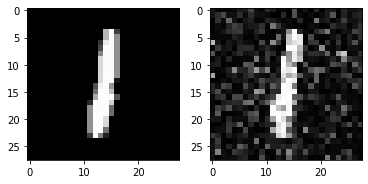

25  :  -0.8795945848538842 25
50  :  -0.8795945848538842 25
75  :  -0.8675757144974392 25
100  :  -0.8675757144974392 25
125  :  -0.8642565188752602 25
150  :  -0.8622954945847363 25
175  :  -0.8435697979578449 25
200  :  -0.7506680769334496 25
225  :  -0.6766653638240889 25
250  :  -0.18971827399004976 25
275  :  0.11360456552401582 25
300  :  0.2831433119563062 25
325  :  0.29524011015896084 25
350  :  0.2957628255343392 25
375  :  0.2957628255343392 25
400  :  0.2957628255343392 25
425  :  0.2957628255343392 25
450  :  0.3089183949616867 25
475  :  0.32576460860347795 25
500  :  0.3312399885979273 25
525  :  0.35259557180185624 25
550  :  0.3545758918949942 25
575  :  0.3673893988894101 25
600  :  0.37212944684026206 25
625  :  0.38483862671604 25
650  :  0.3950455326263811 25
675  :  0.3997845027548239 25
700  :  0.40335484068649613 25
725  :  0.40896421453409976 25
750  :  0.41022114791558745 25
775  :  0.4138735426795359 25
800  :  0.41685693440391414 25
825  :  0.419541772195282

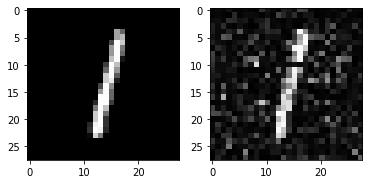

25  :  -0.8779884915370438 25
50  :  -0.8743944663297651 25
75  :  -0.8705974561935251 25
100  :  -0.8659211213981175 25
125  :  -0.860944975103142 25
150  :  -0.8590505659883134 25
175  :  -0.8465398511086595 25
200  :  -0.841084105464015 25
225  :  -0.8255105298960272 25
250  :  -0.7905204526609961 25
275  :  -0.6862563759305975 25
300  :  -0.3724450743250839 25
325  :  0.03503553325645453 25
350  :  0.3917694607055628 25
375  :  0.4025078034366445 25
400  :  0.4025078034366445 25
425  :  0.4025078034366445 25
450  :  0.40912005711002697 25
475  :  0.42179529822203676 25
500  :  0.4216141592617945 25
525  :  0.43698865967671086 25
550  :  0.45280812968323975 25
575  :  0.4530798394027242 25
600  :  0.4530798394027242 25
625  :  0.45894832335807484 25
650  :  0.4623038609298651 25
675  :  0.4668221362749216 25
700  :  0.4689426774309776 25
725  :  0.4689426774309776 25
750  :  0.4689426774309776 25
775  :  0.4731873974394682 25
800  :  0.47318673091677776 25
825  :  0.4740901884336863

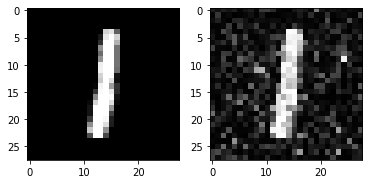

25  :  -0.6333202177112698 25
50  :  -0.5690391007666447 25
75  :  -0.5069690164970035 25
100  :  -0.1834967737323138 25
125  :  0.09926582184239169 25
150  :  0.21217508730555154 25
175  :  0.2840590011874011 25
200  :  0.30130995014284506 25
225  :  0.3606653826026366 25
250  :  0.36245708708155827 25
275  :  0.40111962258048467 25
300  :  0.42875589046242296 25
325  :  0.42875589046242296 25
350  :  0.42875589046242296 25
375  :  0.436955529284628 25
400  :  0.43633148225555635 25
425  :  0.43633148225555635 25
450  :  0.4481520716161824 25
475  :  0.4520429869296611 25
500  :  0.4609211102923567 25
525  :  0.46270390566763686 25
550  :  0.46430810765613206 25
575  :  0.4643370527244888 25
600  :  0.46669978787429006 25
625  :  0.4742943910949592 25
650  :  0.47972321055683337 25
675  :  0.48051948945065764 25
700  :  0.48528403470730985 25
725  :  0.4856711923801823 25
750  :  0.4892553094671321 25
775  :  0.49199229200284156 25
800  :  0.4921571496387391 25
825  :  0.4941509054995

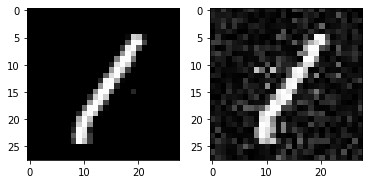

25  :  -0.8826717427394994 25
50  :  -0.8826717427394994 25
75  :  -0.8765462570823853 25
100  :  -0.8731243924440149 25
125  :  -0.8704821048592668 25
150  :  -0.8655338888321975 25
175  :  -0.8647284264167934 25
200  :  -0.858265884167933 25
225  :  -0.8284139314420513 25
250  :  -0.786372031903279 25
275  :  -0.5767742297417671 25
300  :  0.22537375813236465 25
325  :  0.2972032194815982 25
350  :  0.31864481891734064 25
375  :  0.3506250825243996 25
400  :  0.40632098626140073 25
425  :  0.41048443545512253 25
450  :  0.41048443545512253 25
475  :  0.41048443545512253 25
500  :  0.4194039969471017 25
525  :  0.4192979273828324 25
550  :  0.4230849698041325 25
575  :  0.4319895531485137 25
600  :  0.4422299742444935 25
625  :  0.4422299742444935 25
650  :  0.44432603760994377 25
675  :  0.44437711511321737 25
700  :  0.448853928837349 25
725  :  0.45430958527978066 25
750  :  0.45724173196661094 25
775  :  0.4579398576151212 25
800  :  0.46279681336348577 25
825  :  0.46279681336348

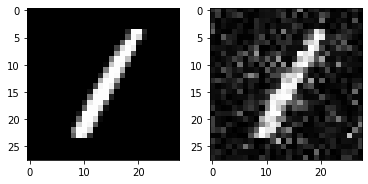

25  :  -0.8927870165220236 25
50  :  -0.8927870165220236 25
75  :  -0.8896852707804519 25
100  :  -0.8854971996906836 25
125  :  -0.8854971996906836 25
150  :  -0.8849314987070296 25
175  :  -0.8807835720694627 25
200  :  -0.8779763193782573 25
225  :  -0.8758726565013971 25
250  :  -0.8723047699591828 25
275  :  -0.8723024240349969 25
300  :  -0.8723024240349969 25
325  :  -0.8721594815892398 25
350  :  -0.869647594220543 25
375  :  -0.869647594220543 25
400  :  -0.8685603682726157 25
425  :  -0.8668055964072306 25
450  :  -0.8668055933052832 25
475  :  -0.866095806923417 25
500  :  -0.8651636512500585 25
525  :  -0.8651630185541882 25
550  :  -0.8643017202313711 25
575  :  -0.8642995539352526 25
600  :  -0.8642995539352526 25
625  :  -0.8642191177238354 25
650  :  -0.8642191177238354 25
675  :  -0.8638926310587417 25
700  :  -0.863673620684542 25
725  :  -0.863673620684542 25
750  :  -0.863673620684542 25
775  :  -0.8635788247480284 25
800  :  -0.8635788247480284 25
Time:  76.5268743

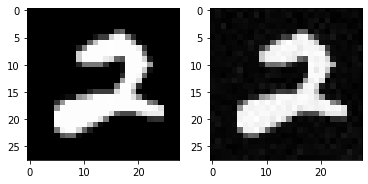

25  :  -0.8874136247133665 25
50  :  -0.8777408107213767 25
75  :  -0.8777408107213767 25
100  :  -0.8777408107213767 25
125  :  -0.8741334181341133 25
150  :  -0.8738843441969579 25
175  :  -0.8728697760675382 25
200  :  -0.8715224173154075 25
225  :  -0.8700766099264807 25
250  :  -0.8660387416828323 25
275  :  -0.8631931976006595 25
300  :  -0.8624666602924864 25
325  :  -0.86221663335017 25
350  :  -0.86087868300686 25
375  :  -0.8602570609637818 25
400  :  -0.8581960439719598 25
425  :  -0.8575039496481359 25
450  :  -0.8565530465131376 25
475  :  -0.8563726459778311 25
500  :  -0.8558417168073889 25
525  :  -0.855673924352431 25
550  :  -0.855673924352431 25
575  :  -0.8551522822709734 25
600  :  -0.8550578811208087 25
625  :  -0.8547935442489305 25
650  :  -0.8544369371764198 25
675  :  -0.8543163150466768 25
700  :  -0.8542077930814398 25
725  :  -0.8540982570792578 25
750  :  -0.8539788250643415 25
775  :  -0.8538072459554473 25
800  :  -0.8537544583124588 25
Time:  76.6727485

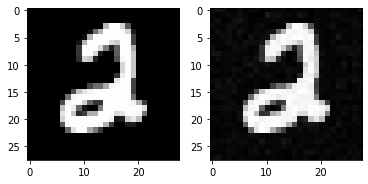

25  :  -0.5466130833281745 25
50  :  -0.5444257953482942 25
75  :  -0.5465710548149485 25
100  :  -0.45321950544304723 25
125  :  -0.39635286643744105 25
150  :  -0.4641630294352238 25
175  :  -0.38961570612920543 25
200  :  -0.2574544962261286 25
225  :  -0.277061959950643 25
250  :  -0.1440132152397196 25
275  :  -0.06955750638855918 25
300  :  0.01871932855677283 25
325  :  0.15616827787897947 25
350  :  0.14154471713375305 25
375  :  0.14154471713375305 25
400  :  0.15434679035755872 25
425  :  0.16416236655529415 25
450  :  0.15936470975409395 25
475  :  0.22099568952554227 25
500  :  0.22099568952554227 25
525  :  0.2519136540355958 25
550  :  0.24945015923752623 25
575  :  0.2811297509640428 25
600  :  0.284064453325333 25
625  :  0.2919889208337203 25
650  :  0.31086230469938697 25
675  :  0.3112435903490897 25
700  :  0.3112435903490897 25
725  :  0.3112435903490897 25
750  :  0.31893511241667055 25
775  :  0.3157565544218349 25
800  :  0.3236872644902032 25
825  :  0.33038111

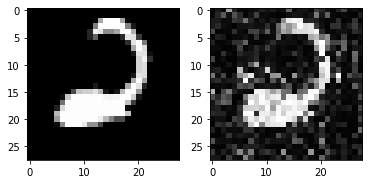

25  :  -0.7947806112491285 25
50  :  -0.7947806112491285 25
75  :  -0.79196073190225 25
100  :  -0.7262489704233019 25
125  :  -0.7187162984587303 25
150  :  -0.5875977789054889 25
175  :  -0.48585936924505074 25
200  :  0.018398224087434967 25
225  :  0.037564096472417874 25
250  :  0.0931006299541266 25
275  :  0.0931006299541266 25
300  :  0.1294606293643244 25
325  :  0.10426767582856472 25
350  :  0.1916662820853094 25
375  :  0.1916662820853094 25
400  :  0.20440873014607064 25
425  :  0.24155303382333232 25
450  :  0.2448335441185565 25
475  :  0.26124880672390266 25
500  :  0.2898968328148831 25
525  :  0.31329973944375283 25
550  :  0.3191530373774912 25
575  :  0.3260684097794497 25
600  :  0.3282525205946672 25
625  :  0.3419969777128865 25
650  :  0.34511845423035964 25
675  :  0.3744291725975721 25
700  :  0.3789482539858059 25
725  :  0.3814796173013467 25
750  :  0.38739040208930814 25
775  :  0.3935896135240273 25
800  :  0.4000355036817555 25
825  :  0.3999492429390068

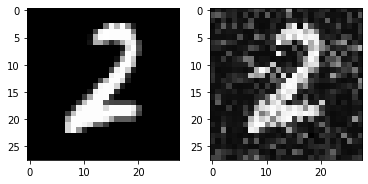

25  :  0.0173899338401442 25
50  :  0.17927990230315471 25
75  :  0.1445239673941064 25
100  :  0.11828098382499941 25
125  :  0.1598807174085225 25
150  :  0.16257408619936614 25
175  :  0.20349280943108555 25
200  :  0.1725282290716384 25
225  :  0.17781374507291903 25
250  :  0.1817296503579381 25
275  :  0.21517791600718816 25
300  :  0.22893958712289836 25
325  :  0.2531118154122207 25
350  :  0.26459236266998687 25
375  :  0.2697281628853486 25
400  :  0.26962910991967776 25
425  :  0.28008225664582187 25
450  :  0.28117198464595144 25
475  :  0.28401048231758713 25
500  :  0.2860815144172887 25
525  :  0.2919593238821924 25
550  :  0.29705120404067115 25
575  :  0.303761059624878 25
600  :  0.30384915145059127 25
625  :  0.314130235376279 25
650  :  0.314171049361858 25
675  :  0.314354302842766 25
700  :  0.31642669690566433 25
725  :  0.316935849191937 25
750  :  0.3182691761000973 25
775  :  0.31923925285230587 25
800  :  0.31923925285230587 25
825  :  0.3218302754422589 25
8

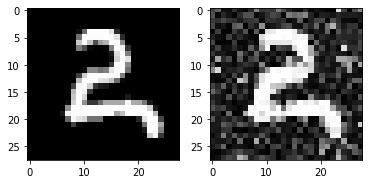

25  :  -0.1882047697573252 25
50  :  -0.18489647671947945 25
75  :  -0.013875386943821538 25
100  :  0.13448920594607033 25
125  :  0.15642596671684594 25
150  :  0.2714261848887838 25
175  :  0.3132888146192696 25
200  :  0.3598639333222342 25
225  :  0.36914355381433406 25
250  :  0.36914355381433406 25
275  :  0.41131114512088385 25
300  :  0.4338077488537314 25
325  :  0.4338077488537314 25
350  :  0.44032776618810704 25
375  :  0.4816543243350141 25
400  :  0.4816543243350141 25
425  :  0.4816543243350141 25
450  :  0.4902867658400476 25
475  :  0.489742799503442 25
500  :  0.49398847741284635 25
525  :  0.5069075342963152 25
550  :  0.5078466415226105 25
575  :  0.5078555590981443 25
600  :  0.5107627408837688 25
625  :  0.5107804664201347 25
650  :  0.5130563335087435 25
675  :  0.5144164663508586 25
700  :  0.5174432627956995 25
725  :  0.5211672787924528 25
750  :  0.5220252064580813 25
775  :  0.5224268513906165 25
800  :  0.5224321329344623 25
825  :  0.5244394631499212 25
8

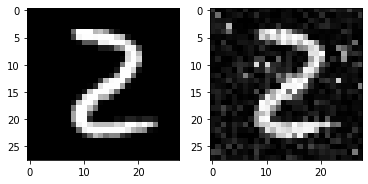

25  :  -0.8371331780046045 25
50  :  -0.8371331780046045 25
75  :  -0.8319679064950559 25
100  :  -0.8243478137658877 25
125  :  -0.8181282145168449 25
150  :  -0.8000528206692409 25
175  :  -0.8000528206692409 25
200  :  -0.8000528206692409 25
225  :  -0.5104715471846132 25
250  :  -0.42488987224065944 25
275  :  0.020350030559790344 25
300  :  0.16205334938536287 25
325  :  0.15348212004507888 25
350  :  0.15348212004507888 25
375  :  0.15384586129685074 25
400  :  0.15954142343280486 25
425  :  0.1950508741708884 25
450  :  0.19373956197044306 25
475  :  0.23341663049703054 25
500  :  0.24195714458826534 25
525  :  0.24442330475890334 25
550  :  0.24442330475890334 25
575  :  0.25251686866555306 25
600  :  0.26343526814328994 25
625  :  0.27035519354019893 25
650  :  0.27035281537588407 25
675  :  0.2756109901930811 25
700  :  0.28007540989229607 25
725  :  0.2854920506857326 25
750  :  0.29262851359020353 25
775  :  0.2961227897946804 25
800  :  0.2962393774557156 25
825  :  0.2985

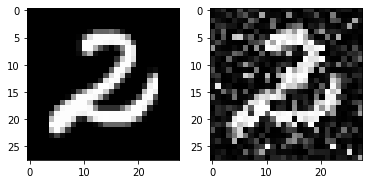

25  :  -0.5639399814084973 25
50  :  -0.5639399814084973 25
75  :  -0.5516128533026161 25
100  :  -0.5343501459689536 25
125  :  -0.501643289944659 25
150  :  -0.3582798411984895 25
175  :  -0.13338307101626848 25
200  :  0.056484578265914076 25
225  :  0.23796665267253575 25
250  :  0.2164773842180649 25
275  :  0.2164773842180649 25
300  :  0.2338110847001118 25
325  :  0.235217606904978 25
350  :  0.25793838885865134 25
375  :  0.27175613198676796 25
400  :  0.29556345801728945 25
425  :  0.29975039853784774 25
450  :  0.30153869004822786 25
475  :  0.30874524197875575 25
500  :  0.3147293130871066 25
525  :  0.3192770491623031 25
550  :  0.3242169108696634 25
575  :  0.32891063420029953 25
600  :  0.3353948825442363 25
625  :  0.34177601623727066 25
650  :  0.34390072338049393 25
675  :  0.35280123302430594 25
700  :  0.3519932170496084 25
725  :  0.3522460036261474 25
750  :  0.3534250720687134 25
775  :  0.35409126763127985 25
800  :  0.35585132887125087 25
825  :  0.358174534157

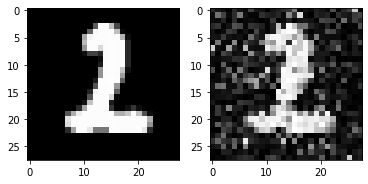

25  :  -0.8857698526399809 25
50  :  -0.879103732672536 25
75  :  -0.8738917942747805 25
100  :  -0.869756650854512 25
125  :  -0.8643752021326138 25
150  :  -0.8644043096274474 25
175  :  -0.8644043096274474 25
200  :  -0.8604681126001538 25
225  :  -0.8604317184825375 25
250  :  -0.8602363206950805 25
275  :  -0.8602363206950805 25
300  :  -0.8602363206950805 25
325  :  -0.8602363206950805 25
350  :  -0.8602363206950805 25
375  :  -0.8600586277913295 25
400  :  -0.8600586277913295 25
425  :  -0.8574290577984937 25
450  :  -0.8553766216451218 25
475  :  -0.8553766216451218 25
500  :  -0.8553766216451218 25
525  :  -0.8553766216451218 25
550  :  -0.8549811779031434 25
575  :  -0.8542110222222288 25
600  :  -0.8540927104008614 25
625  :  -0.8538162116227015 25
650  :  -0.8536510862704294 25
675  :  -0.8531439321022212 25
700  :  -0.8529344265839733 25
725  :  -0.8522731900196585 25
750  :  -0.8522390775602315 25
775  :  -0.8516345496006258 25
800  :  -0.851480206039194 25
Time:  74.2216

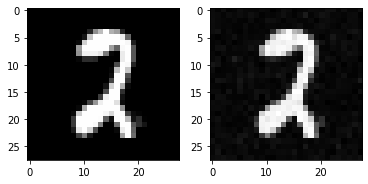

25  :  -0.8082918917898565 25
50  :  -0.7944546018020345 25
75  :  -0.7206626782397513 25
100  :  -0.7148149028601698 25
125  :  -0.48095504357032925 25
150  :  -0.3991226436000777 25
175  :  -0.1313899749314641 25
200  :  0.12721343658279888 25
225  :  0.1758816823596347 25
250  :  0.18848719825770632 25
275  :  0.18848719825770632 25
300  :  0.2042294403890127 25
325  :  0.19773650809046506 25
350  :  0.19773650809046506 25
375  :  0.23728492021945724 25
400  :  0.25888010902969827 25
425  :  0.26322490664559767 25
450  :  0.28175344436291283 25
475  :  0.284226222462127 25
500  :  0.30023513365393856 25
525  :  0.32961439550473326 25
550  :  0.32961439550473326 25
575  :  0.32961439550473326 25
600  :  0.3301797426469987 25
625  :  0.3301797426469987 25
650  :  0.3301797426469987 25
675  :  0.33514908775756874 25
700  :  0.3412057928803253 25
725  :  0.34486506734599615 25
750  :  0.3452691509563122 25
775  :  0.34607702692124537 25
800  :  0.34780749116162996 25
825  :  0.347892043

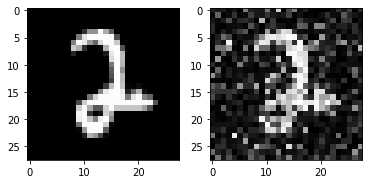

25  :  -0.8840130783998161 25
50  :  -0.8781567976346977 25
75  :  -0.8761415297419548 25
100  :  -0.8744232219233516 25
125  :  -0.867723242514509 25
150  :  -0.867723242514509 25
175  :  -0.8647414486997255 25
200  :  -0.8627484417468348 25
225  :  -0.8633822361453088 25
250  :  -0.8600104737614909 25
275  :  -0.8600104737614909 25
300  :  -0.8574537623987369 25
325  :  -0.8574537623987369 25
350  :  -0.8566941046711268 25
375  :  -0.8547465096387512 25
400  :  -0.8545628458085732 25
425  :  -0.8534237148689586 25
450  :  -0.8520723640833088 25
475  :  -0.8522006552265685 25
500  :  -0.8522006552265685 25
525  :  -0.8495440237375395 25
550  :  -0.8489991553776919 25
575  :  -0.8483137997818689 25
600  :  -0.8473664903231416 25
625  :  -0.8412512459879501 25
650  :  -0.8363755855922159 25
675  :  -0.8313517331170522 25
700  :  -0.8167556650170122 25
725  :  -0.7321837277774284 25
750  :  -0.6204159943088114 25
775  :  -0.19575697276363158 25
800  :  0.08676092092271548 25
825  :  0.13

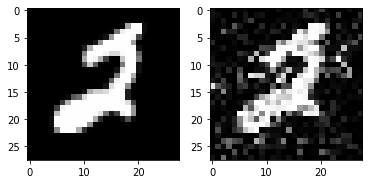

25  :  0.21922176983742162 25
50  :  0.38039782305748815 25
75  :  0.2917906897083715 25
100  :  0.35824198997787876 25
125  :  0.3712186491467067 25
150  :  0.421266629918993 25
175  :  0.4476020722282097 25
200  :  0.478899061388392 25
225  :  0.4730928218145175 25
250  :  0.5088906006099514 25
275  :  0.514963085827782 25
300  :  0.5147536729673906 25
325  :  0.517070087850392 25
350  :  0.5162663507954004 25
375  :  0.5142779432563881 25
400  :  0.5184636017990688 25
425  :  0.5249448903516356 25
450  :  0.5303766221844087 25
475  :  0.5312298854690131 25
500  :  0.5312298854690131 25
525  :  0.5312298854690131 25
550  :  0.5388020466331469 25
575  :  0.5404526894155074 25
600  :  0.5403415680658397 25
625  :  0.544864452182954 25
650  :  0.5451387778102021 25
675  :  0.5463514239966873 25
700  :  0.5496826263450537 25
725  :  0.5528435380622119 25
750  :  0.5527514734842801 25
775  :  0.5560756794355081 25
800  :  0.558452685813067 25
825  :  0.558452685813067 25
850  :  0.5592341

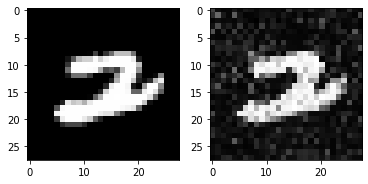

25  :  -0.5761343190865529 25
50  :  -0.19601949573784458 25
75  :  -0.03197366995283224 25
100  :  0.12080078681923667 25
125  :  0.09023932775863963 25
150  :  0.09176387395751573 25
175  :  0.12056169775939451 25
200  :  0.19403348971594453 25
225  :  0.10623710898138061 25
250  :  0.1491859496883835 25
275  :  0.19515496520489106 25
300  :  0.23116651038015912 25
325  :  0.24784957650897999 25
350  :  0.25798042726190473 25
375  :  0.26005662207986047 25
400  :  0.2652028013908261 25
425  :  0.2921128247861181 25
450  :  0.2895608695787679 25
475  :  0.2895608695787679 25
500  :  0.2895608695787679 25
525  :  0.2895608695787679 25
550  :  0.2947672043189978 25
575  :  0.30130750170902004 25
600  :  0.3035255846733913 25
625  :  0.3035255846733913 25
650  :  0.3035255846733913 25
675  :  0.30471865957494354 25
700  :  0.30841500182124504 25
725  :  0.30920530146404873 25
750  :  0.31340772588270677 25
775  :  0.31340772588270677 25
800  :  0.31920021581166996 25
825  :  0.3209511191

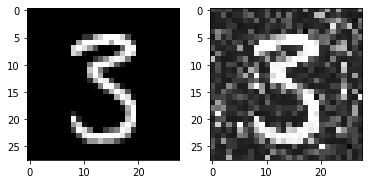

25  :  -0.8079250632335611 25
50  :  -0.7371272992041099 25
75  :  -0.890572633401074 25
100  :  -0.890572633401074 25
125  :  -0.8810489942646127 25
150  :  -0.8777464400745523 25
175  :  -0.8777464400745523 25
200  :  -0.8749914094139905 25
225  :  -0.8708441183547352 25
250  :  -0.8708441183547352 25
275  :  -0.868991858272513 25
300  :  -0.8688323692860954 25
325  :  -0.8682546460314403 25
350  :  -0.8682546460314403 25
375  :  -0.8661879161276952 25
400  :  -0.8652224230334978 25
425  :  -0.864179328796286 25
450  :  -0.8641793703471167 25
475  :  -0.8641793703471167 25
500  :  -0.8641793703471167 25
525  :  -0.8640899286569248 25
550  :  -0.863422778933775 25
575  :  -0.8630016213547744 25
600  :  -0.8630016213547744 25
625  :  -0.8629542951246596 25
650  :  -0.8629542951246596 25
675  :  -0.8623434982852382 25
700  :  -0.8623268374715125 25
725  :  -0.8622139499232182 25
750  :  -0.8620849700749642 25
775  :  -0.8620849700749642 25
800  :  -0.8620849700749642 25
825  :  -0.86205

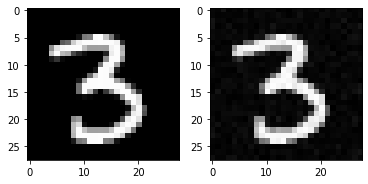

25  :  -0.8913216408889703 25
50  :  -0.8854080105129476 25
75  :  -0.8831549786499057 25
100  :  -0.8830157678264912 25
125  :  -0.879675970485065 25
150  :  -0.879675970485065 25
175  :  -0.8785453015615126 25
200  :  -0.8745262023665363 25
225  :  -0.8745006441616583 25
250  :  -0.8732080193448115 25
275  :  -0.8732080193448115 25
300  :  -0.8714248190400042 25
325  :  -0.8698644928174923 25
350  :  -0.8695994881552652 25
375  :  -0.8695869471195179 25
400  :  -0.8688320469026025 25
425  :  -0.8686772615361675 25
450  :  -0.8662893053427496 25
475  :  -0.8662893053427496 25
500  :  -0.8662893053427496 25
525  :  -0.8661778363287352 25
550  :  -0.8655672692946685 25
575  :  -0.8654859827457839 25
600  :  -0.8650235903367629 25
625  :  -0.8637875496872035 25
650  :  -0.8637875496872035 25
675  :  -0.8637875496872035 25
700  :  -0.862780719319721 25
725  :  -0.862780719319721 25
750  :  -0.862780719319721 25
775  :  -0.8621503348503383 25
800  :  -0.8621503348503383 25
Time:  79.281642

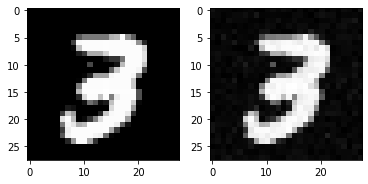

25  :  -0.8734499641360423 25
50  :  -0.7459572857307746 25
75  :  -0.28164888661108267 25
100  :  -0.8832086077994321 25
125  :  -0.8829598900572018 25
150  :  -0.8807207434870727 25
175  :  -0.8795639067318403 25
200  :  -0.8759677081605858 25
225  :  -0.8720283657721372 25
250  :  -0.8696566568965481 25
275  :  -0.8695934703308668 25
300  :  -0.8695934703308668 25
325  :  -0.8695934703308668 25
350  :  -0.8694563965030141 25
375  :  -0.8660530412772055 25
400  :  -0.865276151730688 25
425  :  -0.8654078539645156 25
450  :  -0.8648002731104741 25
475  :  -0.8630886870524578 25
500  :  -0.8630891999875369 25
525  :  -0.8630891999875369 25
550  :  -0.8625447822183885 25
575  :  -0.8616859448759364 25
600  :  -0.8600976319135322 25
625  :  -0.8600976660655085 25
650  :  -0.8600976660655085 25
675  :  -0.8600976660655085 25
700  :  -0.8599069630255551 25
725  :  -0.8594814516798096 25
750  :  -0.8585227042011306 25
775  :  -0.8585227042011306 25
800  :  -0.8585227042011306 25
825  :  -0.

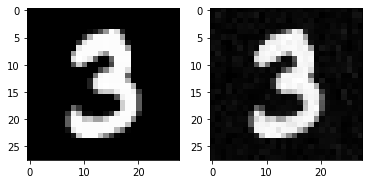

25  :  -0.6788355863593153 25
50  :  -0.17258928198572393 25
75  :  -0.37577839556884995 25
100  :  -0.5129803725836326 25
125  :  -0.8852645543410862 25
150  :  -0.8852621376740955 25
175  :  -0.8852621376740955 25
200  :  -0.8852621376740955 25
225  :  -0.8852621376740955 25
250  :  -0.8852621376740955 25
275  :  -0.8817959923705067 25
300  :  -0.8817959923705067 25
325  :  -0.8813270365502299 25
350  :  -0.8811540844640315 25
375  :  -0.8811540844640315 25
400  :  -0.8811540844640315 25
425  :  -0.8811540844640315 25
450  :  -0.8811540844640315 25
475  :  -0.8811540844640315 25
500  :  -0.8811540844640315 25
525  :  -0.8811540844640315 25
550  :  -0.8811540844640315 25
575  :  -0.879011683960737 25
600  :  -0.8789328517610306 25
625  :  -0.8748979930797985 25
650  :  -0.8748979930797985 25
675  :  -0.8748979930797985 25
700  :  -0.8745177059849584 25
725  :  -0.873718412841643 25
750  :  -0.8718648522891949 25
775  :  -0.8718652804174981 25
800  :  -0.8712530069661096 25
825  :  -0.

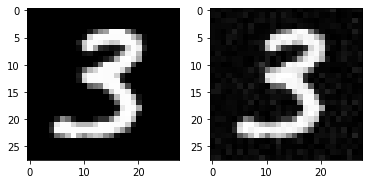

25  :  -0.8834982331199783 25
50  :  -0.8834982331199783 25
75  :  -0.8715246008664719 25
100  :  -0.8715246008664719 25
125  :  -0.8706801508071319 25
150  :  -0.8706801508071319 25
175  :  -0.8674605928509513 25
200  :  -0.8673981065001983 25
225  :  -0.8673981065001983 25
250  :  -0.8673981065001983 25
275  :  -0.8660874557144159 25
300  :  -0.8645007606519384 25
325  :  -0.8645007606519384 25
350  :  -0.8635755767466285 25
375  :  -0.8628037421869615 25
400  :  -0.86193007839303 25
425  :  -0.8616481780781322 25
450  :  -0.8611922944080002 25
475  :  -0.8611922623784263 25
500  :  -0.8610177258939753 25
525  :  -0.8610177258939753 25
550  :  -0.8608336167790147 25
575  :  -0.8607667536835661 25
600  :  -0.8606484797674337 25
625  :  -0.8604917773586922 25
650  :  -0.8602148173683768 25
675  :  -0.8601758182460287 25
700  :  -0.8600999418660259 25
725  :  -0.8600142919174443 25
750  :  -0.8596812975952283 25
775  :  -0.8596940569470083 25
800  :  -0.859646769868667 25
825  :  -0.859

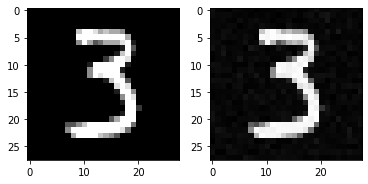

25  :  -0.8974040534249629 25
50  :  -0.8871490651593458 25
75  :  -0.8796885867469328 25
100  :  -0.8796885867469328 25
125  :  -0.8786267538021935 25
150  :  -0.8786267538021935 25
175  :  -0.8786267538021935 25
200  :  -0.8777841988042685 25
225  :  -0.874487754870965 25
250  :  -0.8714341394564789 25
275  :  -0.8714341394564789 25
300  :  -0.8669637319168598 25
325  :  -0.8669637319168598 25
350  :  -0.8669637319168598 25
375  :  -0.8662158572178016 25
400  :  -0.8657578941048065 25
425  :  -0.8657578941048065 25
450  :  -0.8653305123978048 25
475  :  -0.8652270250976155 25
500  :  -0.8652270250976155 25
525  :  -0.8651269298813916 25
550  :  -0.8641648521834292 25
575  :  -0.8632411546300037 25
600  :  -0.8631800668167836 25
625  :  -0.86287364784943 25
650  :  -0.86287364784943 25
675  :  -0.8626187725662617 25
700  :  -0.8626145923218614 25
725  :  -0.8625498812161795 25
750  :  -0.8623860725838522 25
775  :  -0.8623860725838522 25
800  :  -0.8622125545038708 25
825  :  -0.86214

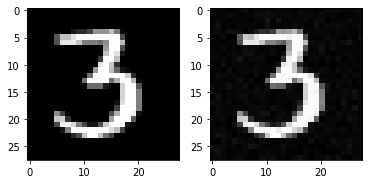

25  :  -0.8970388556127953 25
50  :  -0.8873948110404748 25
75  :  -0.8791185570259888 25
100  :  -0.874741061644536 25
125  :  -0.874741061644536 25
150  :  -0.874741061644536 25
175  :  -0.874741061644536 25
200  :  -0.868388060900981 25
225  :  -0.868388060900981 25
250  :  -0.868388060900981 25
275  :  -0.868388060900981 25
300  :  -0.8679048639965121 25
325  :  -0.8678971989125667 25
350  :  -0.8674668600402404 25
375  :  -0.8661471141022188 25
400  :  -0.8661471141022188 25
425  :  -0.8661471141022188 25
450  :  -0.866027320216122 25
475  :  -0.8653367272865163 25
500  :  -0.8653367272865163 25
525  :  -0.864902386727128 25
550  :  -0.8640573854277142 25
575  :  -0.8637561379205918 25
600  :  -0.8637299138701343 25
625  :  -0.8632141041098998 25
650  :  -0.8632142434371837 25
675  :  -0.8632142434371837 25
700  :  -0.86312524215769 25
725  :  -0.8629338190411857 25
750  :  -0.8629001365631257 25
775  :  -0.8627369215606815 25
800  :  -0.8627369215606815 25
Time:  73.1536343097686

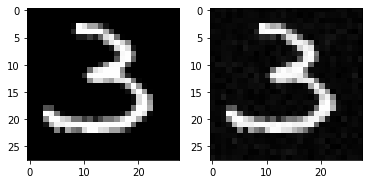

25  :  0.45209512207344177 25
50  :  0.45209512207344177 25
75  :  0.4200212098573465 25
100  :  0.45518097265858426 25
125  :  0.4624408949724099 25
150  :  0.4732594008507427 25
175  :  0.47049155888431116 25
200  :  0.46781538649459686 25
225  :  0.4795775090209457 25
250  :  0.485479188092019 25
275  :  0.4941503660638915 25
300  :  0.49331769098718076 25
325  :  0.4926719172622992 25
350  :  0.5020694909090231 25
375  :  0.5063662219030632 25
400  :  0.5095526013440794 25
425  :  0.5210447988803197 25
450  :  0.5210447988803197 25
475  :  0.5210447988803197 25
500  :  0.5218399248295111 25
525  :  0.5251296551606002 25
550  :  0.5319395133712672 25
575  :  0.5313848970327153 25
600  :  0.5313848970327153 25
625  :  0.5313848970327153 25
650  :  0.5327808874859508 25
675  :  0.5349854101575409 25
700  :  0.5357486947378846 25
725  :  0.5370434081665694 25
750  :  0.537190702913986 25
775  :  0.5411485251459691 25
800  :  0.5419677109656433 25
825  :  0.542578527301253 25
850  :  0.

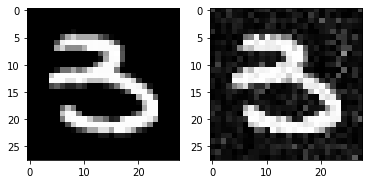

25  :  -0.5645720284978132 25
50  :  -0.42830623359401826 25
75  :  -0.3124902593536011 25
100  :  -0.39861186038165214 25
125  :  -0.0950561304728325 25
150  :  -0.10575291614283211 25
175  :  0.0066974632887448204 25
200  :  0.16588030710447327 25
225  :  0.14975182955764177 25
250  :  0.20518994908566507 25
275  :  0.21116024350969237 25
300  :  0.23452339948381756 25
325  :  0.28126769719226175 25
350  :  0.2768935839472667 25
375  :  0.3411227641770982 25
400  :  0.3914650166304632 25
425  :  0.41307171405586146 25
450  :  0.4203014735757346 25
475  :  0.4292874771306244 25
500  :  0.43004359716945506 25
525  :  0.43004359716945506 25
550  :  0.4338582836812879 25
575  :  0.4357541346347632 25
600  :  0.45374131065088136 25
625  :  0.45373157100293404 25
650  :  0.46143550629427654 25
675  :  0.46143550629427654 25
700  :  0.46145129684517755 25
725  :  0.4614813589943341 25
750  :  0.46529716409491567 25
775  :  0.4715438350046275 25
800  :  0.47204809725626695 25
825  :  0.47204

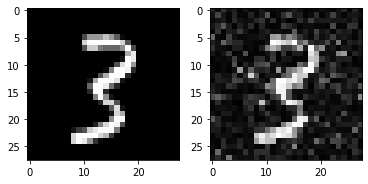

25  :  -0.8953058200871153 25
50  :  -0.8870203945197982 25
75  :  -0.8867133949797598 25
100  :  -0.8845404602012049 25
125  :  -0.8814005829725762 25
150  :  -0.8790147415393367 25
175  :  -0.8782178465669672 25
200  :  -0.8781956045359512 25
225  :  -0.8779819365874617 25
250  :  -0.8761137083665437 25
275  :  -0.8745789247020739 25
300  :  -0.8733382638874801 25
325  :  -0.8716616681817869 25
350  :  -0.8714994899071622 25
375  :  -0.8709025225092953 25
400  :  -0.8691825029076853 25
425  :  -0.8686615704749535 25
450  :  -0.8672262853174015 25
475  :  -0.8660982648819607 25
500  :  -0.8660982648819607 25
525  :  -0.8660982648819607 25
550  :  -0.8651084743432262 25
575  :  -0.8651084743432262 25
600  :  -0.8649781532953652 25
625  :  -0.8644531602894664 25
650  :  -0.8644219421698808 25
675  :  -0.863727541846429 25
700  :  -0.8636332044104393 25
725  :  -0.8636332044104393 25
750  :  -0.8636332044104393 25
775  :  -0.8630405216714798 25
800  :  -0.8630405216714798 25
Time:  72.91

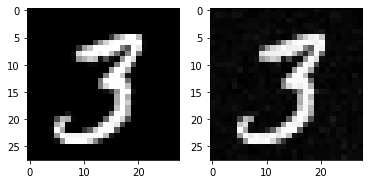

25  :  -0.8867633174904475 25
50  :  -0.4354742652509052 25
75  :  -0.47484164647570654 25
100  :  -0.8747803169964831 25
125  :  -0.8689470439687195 25
150  :  -0.8689470439687195 25
175  :  -0.8642432944397381 25
200  :  -0.8642432944397381 25
225  :  -0.8642432944397381 25
250  :  -0.8642432944397381 25
275  :  -0.8642432944397381 25
300  :  -0.8635226005113241 25
325  :  -0.8635226005113241 25
350  :  -0.8624941416086247 25
375  :  -0.8623981123803548 25
400  :  -0.8623981123803548 25
425  :  -0.8607852969012412 25
450  :  -0.8599102165739716 25
475  :  -0.8599102165739716 25
500  :  -0.857963711561017 25
525  :  -0.857963711561017 25
550  :  -0.857963711561017 25
575  :  -0.8574996534855881 25
600  :  -0.8565935663668687 25
625  :  -0.8560445974131459 25
650  :  -0.8560445974131459 25
675  :  -0.8560445974131459 25
700  :  -0.8560445974131459 25
725  :  -0.8560445974131459 25
750  :  -0.8560445974131459 25
775  :  -0.8559582268416238 25
800  :  -0.8559582268416238 25
825  :  -0.85

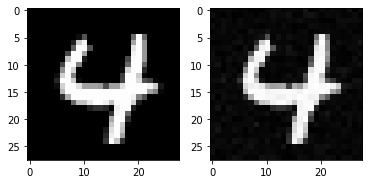

25  :  -0.5812844851155063 25
50  :  -0.2435044004704684 25
75  :  -0.2545011085402712 25
100  :  -0.14068693713476021 25
125  :  -0.3845738170143623 25
150  :  -0.2638950176439889 25
175  :  -0.047366710551444924 25
200  :  -0.045716705611499875 25
225  :  0.030767090448646783 25
250  :  0.052280672248972815 25
275  :  0.17010290561533686 25
300  :  0.1744939067832771 25
325  :  0.1907402985539513 25
350  :  0.1859767669345831 25
375  :  0.23219846720483145 25
400  :  0.23219846720483145 25
425  :  0.23219846720483145 25
450  :  0.2545781222707649 25
475  :  0.2548026868165733 25
500  :  0.27376971294130215 25
525  :  0.27376971294130215 25
550  :  0.275020323764838 25
575  :  0.275020323764838 25
600  :  0.275020323764838 25
625  :  0.2818437791713682 25
650  :  0.28328462608295263 25
675  :  0.2923617139114849 25
700  :  0.2997038393007247 25
725  :  0.30131435981612864 25
750  :  0.3074668941717117 25
775  :  0.30707738068326074 25
800  :  0.3083772203446548 25
825  :  0.3085348435

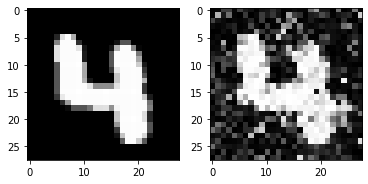

25  :  -0.8497986471664318 25
50  :  -0.5939399858227675 25
75  :  -0.8629432861867059 25
100  :  -0.863860536102032 25
125  :  -0.8502721623703114 25
150  :  -0.8502721623703114 25
175  :  -0.8467011060239825 25
200  :  -0.8484243624012833 25
225  :  -0.8463618276858014 25
250  :  -0.7806736785656534 25
275  :  -0.8229061888627455 25
300  :  -0.8134304642394603 25
325  :  -0.7110813357419549 25
350  :  -0.5219355162771984 25
375  :  -0.10624370620783108 25
400  :  0.15655024153005814 25
425  :  0.15573614687739218 25
450  :  0.11482104118980946 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


475  :  0.12181905737879317 25
500  :  0.1703044013596267 25
525  :  0.19422512820020504 25
550  :  0.19528491459430408 25
575  :  0.21344225697885127 25
600  :  0.21344225697885127 25
625  :  0.22730082267410145 25
650  :  0.2366642017435649 25
675  :  0.23566716858293785 25
700  :  0.2703431118959071 25
725  :  0.2689132054543464 25
750  :  0.2866552763115554 25
775  :  0.2929745558168533 25
800  :  0.2929745558168533 25
825  :  0.2929745558168533 25
850  :  0.2929745558168533 25
875  :  0.3043258506430912 25
900  :  0.30784622958304775 25
925  :  0.32738131263372083 25
950  :  0.32738131263372083 25
975  :  0.32738131263372083 25
1000  :  0.32738131263372083 25
1025  :  0.3302396890980883 25
1050  :  0.3354756619740444 25
1075  :  0.3405556610317765 25
1100  :  0.34132311948316874 25
1125  :  0.34444452831473293 25
1150  :  0.3449509776469594 25
1175  :  0.35025147789893024 25
1199  :  0.3572220488088675 24
1223  :  0.3571135663890682 24
1247  :  0.3571135663890682 24
1271  :  0.361

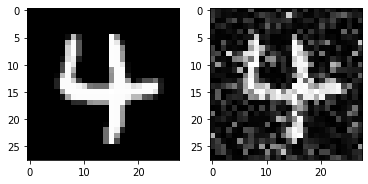

25  :  -0.8750861284571247 25
50  :  -0.8750861284571247 25
75  :  -0.8746318982889478 25
100  :  -0.8746318982889478 25
125  :  -0.8746318982889478 25
150  :  -0.8701758840213132 25
175  :  -0.8710554784658997 25
200  :  -0.8665960417609753 25
225  :  -0.8665960417609753 25
250  :  -0.8661492261699879 25
275  :  -0.8640777981607902 25
300  :  -0.8640903682535935 25
325  :  -0.8640903682535935 25
350  :  -0.8633179014322181 25
375  :  -0.8611736694041434 25
400  :  -0.8594786609150673 25
425  :  -0.8592867526723759 25
450  :  -0.8592867526723759 25
475  :  -0.858650468265849 25
500  :  -0.8582984335541717 25
525  :  -0.8582984335541717 25
550  :  -0.8582984335541717 25
575  :  -0.858007837788229 25
600  :  -0.857971296026565 25
625  :  -0.857971296026565 25
650  :  -0.8577265888346228 25
675  :  -0.8575098511338956 25
700  :  -0.8571820502110267 25
725  :  -0.8567431516318448 25
750  :  -0.8567431516318448 25
775  :  -0.856587126810112 25
800  :  -0.8565571801193869 25
Time:  77.022090

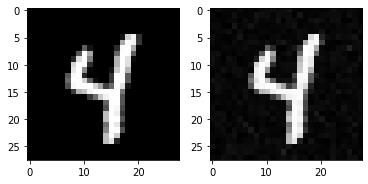

25  :  -0.6207991809396719 25
50  :  0.058603349937823235 25
75  :  -0.020115522954202214 25
100  :  0.1102363873295179 25
125  :  0.16077861914907032 25
150  :  0.16077861914907032 25
175  :  0.16077861914907032 25
200  :  0.16077861914907032 25
225  :  0.18046387556706495 25
250  :  0.1947990225879101 25
275  :  0.20760210282627767 25
300  :  0.22536710730284304 25
325  :  0.23353018540181258 25
350  :  0.25125548804104086 25
375  :  0.293146014829495 25
400  :  0.293146014829495 25
425  :  0.293146014829495 25
450  :  0.293146014829495 25
475  :  0.30328657313344937 25
500  :  0.3241846934996883 25
525  :  0.3234976656990143 25
550  :  0.3497614069998487 25
575  :  0.34932503779474544 25
600  :  0.35285440338214413 25
625  :  0.35990390873982075 25
650  :  0.35993779955368504 25
675  :  0.3770747348915941 25
700  :  0.37447030364937567 25
725  :  0.37447030364937567 25
750  :  0.3866749135819184 25
775  :  0.389745097794663 25
800  :  0.40049839529034215 25
825  :  0.410741090444284

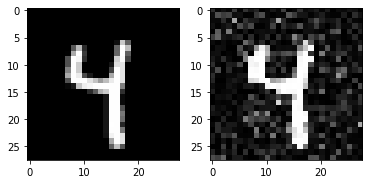

25  :  -0.736320564287676 25
50  :  -0.40726218022114546 25
75  :  -0.47202148445177705 25
100  :  0.0003523481512768267 25
125  :  0.3149170344774547 25
150  :  0.3753185610594011 25
175  :  0.38360252319706384 25
200  :  0.4437714643383402 25
225  :  0.4541517145301167 25
250  :  0.4541517145301167 25
275  :  0.4541517145301167 25
300  :  0.4541517145301167 25
325  :  0.46294046789264925 25
350  :  0.46294046789264925 25
375  :  0.4914711529585843 25
400  :  0.4914711529585843 25
425  :  0.4914711529585843 25
450  :  0.4928317421438129 25
475  :  0.4928317421438129 25
500  :  0.4928317421438129 25
525  :  0.5021421449562786 25
550  :  0.5021714272653517 25
575  :  0.5041368440488747 25
600  :  0.509157627928291 25
625  :  0.5107300551213914 25
650  :  0.5137536582584341 25
675  :  0.52049739535445 25
700  :  0.5204883695840711 25
725  :  0.5204883695840711 25
750  :  0.5204883695840711 25
775  :  0.5214152525569994 25
800  :  0.5216268431942157 25
825  :  0.5233815884892034 25
850  :

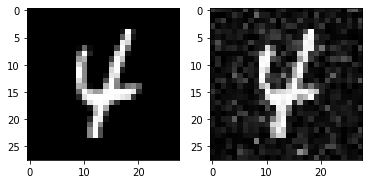

25  :  -0.8603320506284658 25
50  :  -0.8389029689992509 25
75  :  -0.8157496070467916 25
100  :  -0.7717566400790724 25
125  :  -0.7617881849224581 25
150  :  -0.6010428999222162 25
175  :  0.05259863220085359 25
200  :  0.05571825011845288 25
225  :  0.20999097852669446 25
250  :  0.24828589795180478 25
275  :  0.2554981706958534 25
300  :  0.2795469145610668 25
325  :  0.3262691211044553 25
350  :  0.3262691211044553 25
375  :  0.3262691211044553 25
400  :  0.3326424401427138 25
425  :  0.33430430425615304 25
450  :  0.3425772733185988 25
475  :  0.35206362697755417 25
500  :  0.35548568056921687 25
525  :  0.3580223214220446 25
550  :  0.3734150814641964 25
575  :  0.3734150814641964 25
600  :  0.37912493111927725 25
625  :  0.3791375414673118 25
650  :  0.3879977371835931 25
675  :  0.39851905662524545 25
700  :  0.3985129953050792 25
725  :  0.3985129953050792 25
750  :  0.4043068578142096 25
775  :  0.404382082405817 25
800  :  0.4047718403280788 25
825  :  0.4068222978258928 25

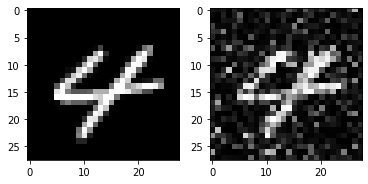

25  :  -0.893226560050239 25
50  :  -0.893226560050239 25
75  :  -0.8903252841044599 25
100  :  -0.8829537839086892 25
125  :  -0.8829537839086892 25
150  :  -0.8829537839086892 25
175  :  -0.8793001652340525 25
200  :  -0.8774695272742592 25
225  :  -0.8758760136832757 25
250  :  -0.8755511692501224 25
275  :  -0.8742285284247496 25
300  :  -0.8690812945523416 25
325  :  -0.8685399558564291 25
350  :  -0.8679841373864275 25
375  :  -0.8679626375113872 25
400  :  -0.8670452220528697 25
425  :  -0.8662846206743339 25
450  :  -0.8660677437966781 25
475  :  -0.8660677437966781 25
500  :  -0.8660677437966781 25
525  :  -0.8659974483972558 25
550  :  -0.8654014883457007 25
575  :  -0.8654014883457007 25
600  :  -0.8648606885342464 25
625  :  -0.8648606885342464 25
650  :  -0.8646398650211068 25
675  :  -0.8646192177768856 25
700  :  -0.8645546924137724 25
725  :  -0.8643191591692427 25
750  :  -0.8642131169299113 25
775  :  -0.8639349581683087 25
800  :  -0.8639349581683087 25
Time:  76.477

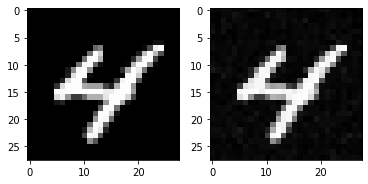

25  :  -0.6645754819152456 25
50  :  0.135014713191413 25
75  :  -0.014818052334697573 25
100  :  0.14323906394533942 25
125  :  0.17540561245153363 25
150  :  0.1935135956441647 25
175  :  0.24920973364079396 25
200  :  0.24281339358158216 25
225  :  0.25055190541964206 25
250  :  0.2744322271421356 25
275  :  0.26206086252777566 25
300  :  0.297802850509185 25
325  :  0.2936883160482566 25
350  :  0.29267678937142505 25
375  :  0.31188693103288007 25
400  :  0.31188693103288007 25
425  :  0.31188693103288007 25
450  :  0.3202319612852919 25
475  :  0.3206580253291163 25
500  :  0.3206580253291163 25
525  :  0.32857042661931524 25
550  :  0.3321915134358579 25
575  :  0.33627339696162933 25
600  :  0.33578909937581514 25
625  :  0.33638574134219773 25
650  :  0.33963712967771925 25
675  :  0.3422121206018535 25
700  :  0.3483431464527821 25
725  :  0.3488415853145123 25
750  :  0.3487531913647436 25
775  :  0.3516740196401052 25
800  :  0.35359474128941326 25
825  :  0.353594741289413

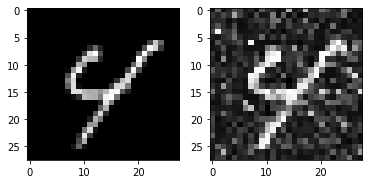

25  :  -0.75307936039097 25
50  :  -0.06006965008567655 25
75  :  -0.8711194079295203 25
100  :  -0.8693745212044816 25
125  :  -0.8693882059942183 25
150  :  -0.8693882059942183 25
175  :  -0.8693882059942183 25
200  :  -0.8693882059942183 25
225  :  -0.8683133254094411 25
250  :  -0.8683133254094411 25
275  :  -0.8683133254094411 25
300  :  -0.8642463334902202 25
325  :  -0.8633567895797043 25
350  :  -0.862119776391638 25
375  :  -0.8590919692169504 25
400  :  -0.8578922278922984 25
425  :  -0.8564974810285488 25
450  :  -0.8541781933850856 25
475  :  -0.8541784526083723 25
500  :  -0.8514468209604299 25
525  :  -0.851133582348301 25
550  :  -0.8484403346066308 25
575  :  -0.8476918799852586 25
600  :  -0.8440372216072163 25
625  :  -0.7978975462446195 25
650  :  -0.6528783136212724 25
675  :  -0.23722692326194283 25
700  :  0.2669565935387819 25
725  :  0.29899577050765197 25
750  :  0.26883391855276983 25
775  :  0.2616536595229475 25
800  :  0.3134736084652791 25
825  :  0.309644

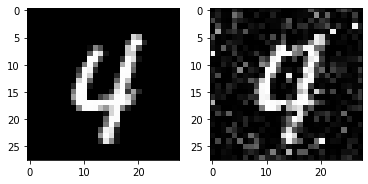

25  :  -0.4542245955630769 25
50  :  -0.09287596177733715 25
75  :  -0.42209436394426814 25
100  :  -0.0207791710186066 25
125  :  0.0018575755415972672 25
150  :  0.11734186435448035 25
175  :  0.1534718771502918 25
200  :  0.1534718771502918 25
225  :  0.16541072535200013 25
250  :  0.16541072535200013 25
275  :  0.1733782523082329 25
300  :  0.22855791906161077 25
325  :  0.22919806681482285 25
350  :  0.21581834853883453 25
375  :  0.2802841359894811 25
400  :  0.25771219487879066 25
425  :  0.27398224030611174 25
450  :  0.30845400886228946 25
475  :  0.3508087631159512 25
500  :  0.3508087631159512 25
525  :  0.3559200744319748 25
550  :  0.3589779818741972 25
575  :  0.3838060371941075 25
600  :  0.4012948936362585 25
625  :  0.409783572893508 25
650  :  0.4127016667690829 25
675  :  0.4128178980278276 25
700  :  0.4175662396000877 25
725  :  0.41767029496105307 25
750  :  0.4196376306400117 25
775  :  0.4184317295704659 25
800  :  0.42005175798340283 25
825  :  0.41970810534550

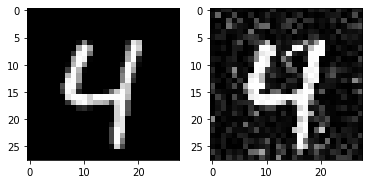

25  :  0.053203990454671835 25
50  :  0.25357333731635606 25
75  :  0.23279831295990971 25
100  :  0.2588352913101679 25
125  :  0.252567531535977 25
150  :  0.2785292682297463 25
175  :  0.28134393250593037 25
200  :  0.2790491500192606 25
225  :  0.28868395645281536 25
250  :  0.28868395645281536 25
275  :  0.28868395645281536 25
300  :  0.28868395645281536 25
325  :  0.3082068819979481 25
350  :  0.30441824812640417 25
375  :  0.314639624179047 25
400  :  0.33216723754152544 25
425  :  0.33216723754152544 25
450  :  0.34337303716138984 25
475  :  0.3493548993446811 25
500  :  0.35102396635657507 25
525  :  0.35102396635657507 25
550  :  0.3550410167624223 25
575  :  0.3617805821547434 25
600  :  0.3617805821547434 25
625  :  0.365230309716543 25
650  :  0.3656285351437476 25
675  :  0.37093762240579053 25
700  :  0.3742304748522216 25
725  :  0.3784000629069587 25
750  :  0.3783736687528897 25
775  :  0.3784622384443756 25
800  :  0.3846481884951516 25
825  :  0.3846481884951516 25


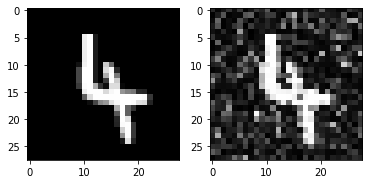

25  :  -0.6850981397377094 25
50  :  -0.273132273373202 25
75  :  -0.07071026817149234 25
100  :  0.042295202596698805 25
125  :  0.14561893439025064 25
150  :  0.27362159113216866 25
175  :  0.3063804915066501 25
200  :  0.32769429473278944 25
225  :  0.3721060773185806 25
250  :  0.3721060773185806 25
275  :  0.41807189516801935 25
300  :  0.41807189516801935 25
325  :  0.41807189516801935 25
350  :  0.41807189516801935 25
375  :  0.4309630077701108 25
400  :  0.44193468731747293 25
425  :  0.443694286070682 25
450  :  0.4519954994160874 25
475  :  0.4519954994160874 25
500  :  0.4540941066517026 25
525  :  0.46468353443455324 25
550  :  0.465115116085475 25
575  :  0.4668905057765271 25
600  :  0.4710426041541415 25
625  :  0.4772992835134281 25
650  :  0.48255049837865366 25
675  :  0.48255049837865366 25
700  :  0.48593984099354137 25
725  :  0.49004005273813783 25
750  :  0.4908699182283216 25
775  :  0.49209645662295043 25
800  :  0.49377977908695486 25
825  :  0.496203179422935

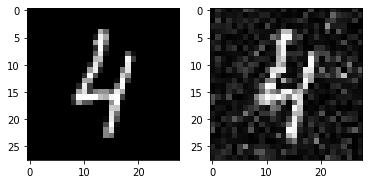

25  :  -0.8010069143478816 25
50  :  -0.8010069143478816 25
75  :  -0.7978723402777215 25
100  :  -0.7711498197001867 25
125  :  -0.7656670410376932 25
150  :  -0.7076878911776742 25
175  :  -0.657675054773355 25
200  :  -0.6441010047549687 25
225  :  -0.5686675780036781 25
250  :  -0.2501529844817139 25
275  :  -0.17621756836303315 25
300  :  -0.07765251227552017 25
325  :  -0.05088536336550617 25
350  :  -0.02939067645086793 25
375  :  0.048813243129074646 25
400  :  0.0843588260062918 25
425  :  0.09186546383345978 25
450  :  0.09324724132621104 25
475  :  0.09331502319109858 25
500  :  0.1355209380790674 25
525  :  0.1715355743036059 25
550  :  0.1827353617398227 25
575  :  0.18284224282501788 25
600  :  0.2005523426000979 25
625  :  0.21397372423897043 25
650  :  0.227024002061194 25
675  :  0.22906933799750012 25
700  :  0.2473919861021393 25
725  :  0.25784719491959596 25
750  :  0.26608657813003384 25
775  :  0.2772619989116261 25
800  :  0.28960451929463726 25
825  :  0.299066

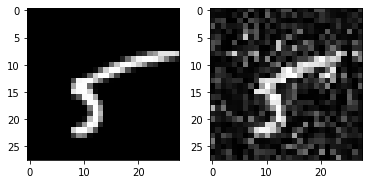

25  :  -0.7554756300985299 25
50  :  -0.7554756300985299 25
75  :  -0.7212139708037184 25
100  :  -0.6756271981683605 25
125  :  -0.6464471279412239 25
150  :  -0.5072801233281143 25
175  :  -0.5031282452098893 25
200  :  -0.5030449207946694 25
225  :  -0.28513252358373414 25
250  :  -0.26752177278424627 25
275  :  -0.053466785312809184 25
300  :  -0.06654858862619034 25
325  :  0.03896073632801883 25
350  :  0.13093465106867747 25
375  :  0.15951954535981283 25
400  :  0.19992433005869892 25
425  :  0.20673378136714832 25
450  :  0.3288594196459232 25
475  :  0.3256498377774702 25
500  :  0.3256498377774702 25
525  :  0.33585465624001914 25
550  :  0.3391011861317277 25
575  :  0.3517633518862689 25
600  :  0.36419594702430325 25
625  :  0.37716634532381527 25
650  :  0.38492890389112455 25
675  :  0.3906676232292833 25
700  :  0.394226472495467 25
725  :  0.39862187213591155 25
750  :  0.40033802659586365 25
775  :  0.4082695350818047 25
800  :  0.41092126878862273 25
825  :  0.41092

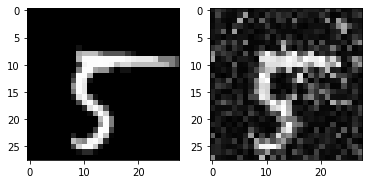

25  :  -0.8564368435121623 25
50  :  -0.8548984684275472 25
75  :  -0.8430996822886742 25
100  :  -0.8370595843033397 25
125  :  -0.8365795588441676 25
150  :  -0.8268017112077963 25
175  :  -0.8268017112077963 25
200  :  -0.8237528859828731 25
225  :  -0.8237528859828731 25
250  :  -0.8237528859828731 25
275  :  -0.8237528859828731 25
300  :  -0.8212072742189209 25
325  :  -0.8147517856000674 25
350  :  -0.8101736660432943 25
375  :  -0.8081280813994847 25
400  :  -0.7993696337003183 25
425  :  -0.7938567666412806 25
450  :  -0.7679646369243622 25
475  :  -0.7093906278711279 25
500  :  -0.6149081030843051 25
525  :  -0.5438571710341132 25
550  :  -0.2996839768199081 25
575  :  -0.1713016784664983 25
600  :  -0.19579638264790644 25
625  :  -0.19579638264790644 25
650  :  -0.1429008360137071 25
675  :  -0.12674388561072397 25
700  :  -0.12322269911386297 25
725  :  -0.12594105286015694 25
750  :  -0.0914598675835705 25
775  :  -0.04262061116519433 25
800  :  -0.02873673028908541 25
825 

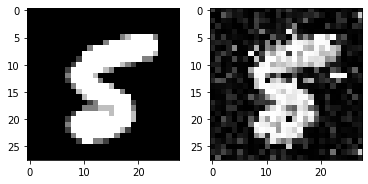

25  :  -0.8903779573756312 25
50  :  -0.8863264064466435 25
75  :  -0.8771348701442757 25
100  :  -0.8771348701442757 25
125  :  -0.8765723498616509 25
150  :  -0.8761839648439566 25
175  :  -0.8718110584707718 25
200  :  -0.8714722398284872 25
225  :  -0.8714722398284872 25
250  :  -0.8714722398284872 25
275  :  -0.8681444607589823 25
300  :  -0.8652390913494452 25
325  :  -0.8652390913494452 25
350  :  -0.86438891527409 25
375  :  -0.8643838835898662 25
400  :  -0.862802230690014 25
425  :  -0.8624258326894939 25
450  :  -0.8608770229146234 25
475  :  -0.860743658617395 25
500  :  -0.8588324815415209 25
525  :  -0.8588324815415209 25
550  :  -0.8588324815415209 25
575  :  -0.8588324815415209 25
600  :  -0.8581555591667877 25
625  :  -0.8576620436022436 25
650  :  -0.8574889121922895 25
675  :  -0.8570464497368501 25
700  :  -0.8568147791378143 25
725  :  -0.8564786316658286 25
750  :  -0.8559864235124298 25
775  :  -0.8559864235124298 25
800  :  -0.8559864235124298 25
Time:  94.34095

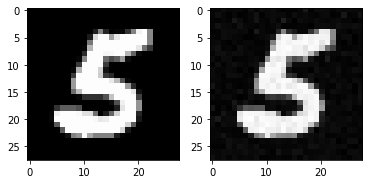

25  :  -0.8834257213154615 25
50  :  -0.8834257213154615 25
75  :  -0.8768895224000285 25
100  :  -0.8768895224000285 25
125  :  -0.8768895224000285 25
150  :  -0.8709938088562087 25
175  :  -0.8658580978174644 25
200  :  -0.8657250345079166 25
225  :  -0.8657250345079166 25
250  :  -0.8627479260452928 25
275  :  -0.8610190447733074 25
300  :  -0.8555570172803033 25
325  :  -0.8555570172803033 25
350  :  -0.8529911612631187 25
375  :  -0.8530815438994797 25
400  :  -0.8527102915837672 25
425  :  -0.8527037329867521 25
450  :  -0.8527037329867521 25
475  :  -0.8524197525629768 25
500  :  -0.8524197525629768 25
525  :  -0.8519336867809806 25
550  :  -0.8509416750708797 25
575  :  -0.8502531968987057 25
600  :  -0.8499221698529038 25
625  :  -0.849507587598822 25
650  :  -0.849507587598822 25
675  :  -0.848611091240682 25
700  :  -0.8481958371691499 25
725  :  -0.847383632185643 25
750  :  -0.8472453117542215 25
775  :  -0.8463354798837049 25
800  :  -0.8463403932158053 25
Time:  91.81974

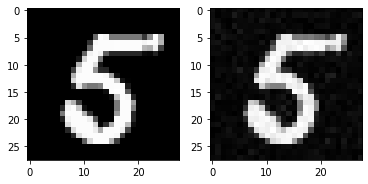

25  :  -0.6959404181524335 25
50  :  -0.6327015208391072 25
75  :  -0.6297346061217858 25
100  :  -0.6383768397105074 25
125  :  -0.6054751535236409 25
150  :  -0.5770968217692762 25
175  :  -0.5023387998141713 25
200  :  -0.39701871479554995 25
225  :  -0.30619673920297963 25
250  :  -0.08119184861780815 25
275  :  0.07547502275190132 25
300  :  0.23157329086487377 25
325  :  0.3459779264969473 25
350  :  0.33151490742402656 25
375  :  0.33151490742402656 25
400  :  0.33151490742402656 25
425  :  0.38951526243606305 25
450  :  0.3893122223399456 25
475  :  0.39610184364994344 25
500  :  0.398843369126386 25
525  :  0.398843369126386 25
550  :  0.4058599667122656 25
575  :  0.424939327585637 25
600  :  0.424939327585637 25
625  :  0.43502451503864825 25
650  :  0.43502451503864825 25
675  :  0.43945886037389453 25
700  :  0.44799876126751925 25
725  :  0.45165932653507473 25
750  :  0.4509422958789627 25
775  :  0.4565704828894644 25
800  :  0.45768780266273745 25
825  :  0.45794317386

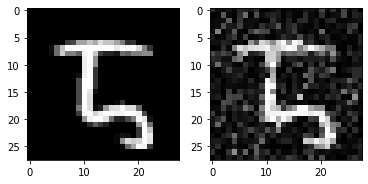

25  :  0.6357742403195497 25
50  :  0.6357742403195497 25
75  :  0.6440119577108608 25
100  :  0.6521463346881176 25
125  :  0.6528100681535577 25
150  :  0.6567563810146025 25
175  :  0.6567563810146025 25
200  :  0.6589437720369378 25
225  :  0.6624334418299235 25
250  :  0.6706197444495343 25
275  :  0.6706197444495343 25
300  :  0.6717700744875063 25
325  :  0.6751963580361982 25
350  :  0.6751963580361982 25
375  :  0.6763110862183572 25
400  :  0.676103024510523 25
425  :  0.6803989782710382 25
450  :  0.6813915135414357 25
475  :  0.6813810295250097 25
500  :  0.6813810295250097 25
525  :  0.6817627995678626 25
550  :  0.6824742006992333 25
575  :  0.6829468382902225 25
600  :  0.6838489908421456 25
625  :  0.6838489908421456 25
650  :  0.6849919250020937 25
675  :  0.6849919250020937 25
700  :  0.6851392393588468 25
725  :  0.685254514067487 25
750  :  0.6855226934256993 25
775  :  0.6868275797377132 25
800  :  0.6868479836558147 25
Time:  85.36056852340698  seconds
Predicted c

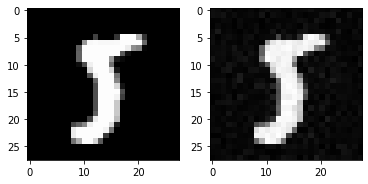

25  :  0.3159837520692709 25
50  :  0.41202431045859506 25
75  :  0.43677718817150646 25
100  :  0.43346965610341615 25
125  :  0.48060931733346635 25
150  :  0.5181121450921277 25
175  :  0.5257885770044212 25
200  :  0.5538513425565659 25
225  :  0.5654818097718929 25
250  :  0.5829886184151684 25
275  :  0.5967411537312419 25
300  :  0.5965806160806917 25
325  :  0.6001748290341435 25
350  :  0.6063451682443642 25
375  :  0.6060684363543728 25
400  :  0.6080438748908052 25
425  :  0.6125015380383444 25
450  :  0.6133876429541624 25
475  :  0.6135716604224037 25
500  :  0.6135550214034644 25
525  :  0.6154892889729654 25
550  :  0.6156810802213939 25
575  :  0.6161423638810456 25
600  :  0.6197258600144677 25
625  :  0.6197384711025015 25
650  :  0.6228806341430713 25
675  :  0.6229043336944216 25
700  :  0.6233300087443072 25
725  :  0.6242273600929539 25
750  :  0.624710372324118 25
775  :  0.6254320136742344 25
800  :  0.6257662236805229 25
825  :  0.6258810176239806 25
850  :  0.

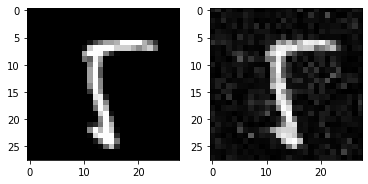

25  :  -0.36861582044113683 25
50  :  -0.20172372085047924 25
75  :  -0.13506304303879313 25
100  :  -0.14450086522274963 25
125  :  0.22761699496765442 25
150  :  0.21443288913496228 25
175  :  0.32824574438420095 25
200  :  0.42831734248174247 25
225  :  0.4623119812286743 25
250  :  0.467320820416568 25
275  :  0.467320820416568 25
300  :  0.47933859243356297 25
325  :  0.4811483583123065 25
350  :  0.48374724727516566 25
375  :  0.4856024828248159 25
400  :  0.48827695361345225 25
425  :  0.4902941467365413 25
450  :  0.5042302609774656 25
475  :  0.5110505887283618 25
500  :  0.5166699151018714 25
525  :  0.516706117943239 25
550  :  0.5201006465817841 25
575  :  0.5225094410764315 25
600  :  0.5232681191159588 25
625  :  0.5232681191159588 25
650  :  0.5293876431452229 25
675  :  0.5293784767672032 25
700  :  0.5301001606432013 25
725  :  0.5301001606432013 25
750  :  0.5315593774161514 25
775  :  0.5318904238361342 25
800  :  0.5323209989575725 25
825  :  0.5334312876796447 25
8

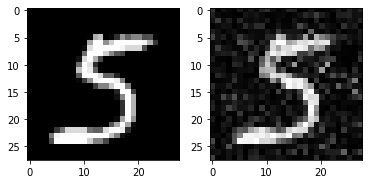

25  :  -0.2032050378596888 25
50  :  -0.17483530842805264 25
75  :  -0.04713098141156738 25
100  :  -0.07149295301578855 25
125  :  -0.005705263661721249 25
150  :  0.1759919141479302 25
175  :  0.32691314131207305 25
200  :  0.3587986179446242 25
225  :  0.37566805836542844 25
250  :  0.3821513915671719 25
275  :  0.383937967568734 25
300  :  0.3983096836804855 25
325  :  0.40545385281094265 25
350  :  0.4089790872433137 25
375  :  0.42380791957897834 25
400  :  0.4333612014342324 25
425  :  0.43323125444998445 25
450  :  0.43323125444998445 25
475  :  0.4337691852486899 25
500  :  0.4337691852486899 25
525  :  0.4419358116804653 25
550  :  0.45426479124029473 25
575  :  0.4541856784099333 25
600  :  0.4541856784099333 25
625  :  0.4547449778475595 25
650  :  0.4574084482186403 25
675  :  0.45750969795550317 25
700  :  0.459177296995928 25
725  :  0.45984793177303557 25
750  :  0.46617980282258786 25
775  :  0.4671681576117403 25
800  :  0.4682795940429953 25
825  :  0.471328163908559

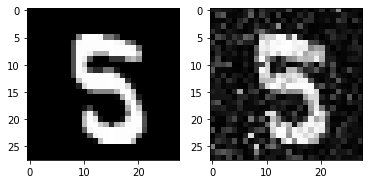

25  :  0.28498548287519654 25
50  :  0.33490785135612255 25
75  :  0.38211317692582425 25
100  :  0.4567975701446332 25
125  :  0.495600710191021 25
150  :  0.495600710191021 25
175  :  0.5012617562288595 25
200  :  0.5097678429365098 25
225  :  0.5166406346016348 25
250  :  0.5291035119226501 25
275  :  0.5550090288611238 25
300  :  0.5562244647656319 25
325  :  0.5562244647656319 25
350  :  0.5562244647656319 25
375  :  0.5562244647656319 25
400  :  0.5562244647656319 25
425  :  0.5580295216301242 25
450  :  0.5633035070441428 25
475  :  0.5662938326415635 25
500  :  0.5692827071029007 25
525  :  0.5717911592137807 25
550  :  0.5741841459427264 25
575  :  0.5759414336052509 25
600  :  0.5775502663519596 25
625  :  0.5838324464797429 25
650  :  0.5838324464797429 25
675  :  0.586547648137431 25
700  :  0.586547648137431 25
725  :  0.5888035307928956 25
750  :  0.5888035307928956 25
775  :  0.5892036826421665 25
800  :  0.5892036826421665 25
825  :  0.5892036826421665 25
850  :  0.5892

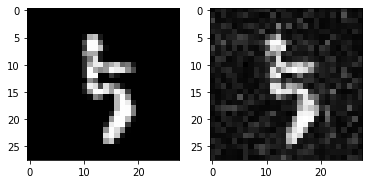

25  :  -0.746360874492804 25
50  :  -0.746360874492804 25
75  :  -0.7348199379331033 25
100  :  -0.7461754086810484 25
125  :  -0.7440513360317682 25
150  :  -0.7319198540683705 25
175  :  -0.7062264855744288 25
200  :  -0.6990971758132094 25
225  :  -0.6580721478245926 25
250  :  -0.5985551998254671 25
275  :  -0.4521832606539219 25
300  :  -0.31500883873774815 25
325  :  -0.11664743156816557 25
350  :  0.08508413079398947 25
375  :  -0.002662514522146775 25
400  :  0.047508572940739235 25
425  :  0.12037545716787973 25
450  :  0.015811125801962034 25
475  :  0.07733088038520286 25
500  :  0.07733088038520286 25
525  :  0.1632558905846378 25
550  :  0.17225225405466654 25
575  :  0.17225225405466654 25
600  :  0.17225225405466654 25
625  :  0.1971689302716979 25
650  :  0.22218708616808275 25
675  :  0.2176593829265746 25
700  :  0.2168150790467107 25
725  :  0.23358013716441883 25
750  :  0.2327320965448671 25
775  :  0.2476858387036721 25
800  :  0.26052855070509484 25
825  :  0.271

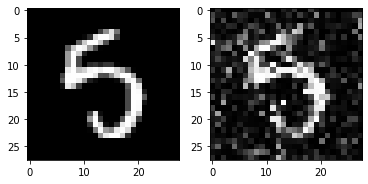

25  :  0.5536143824288194 25
50  :  0.5536143824288194 25
75  :  0.5729108017370476 25
100  :  0.5822208814882324 25
125  :  0.5845611570285193 25
150  :  0.5926115112827196 25
175  :  0.593621447772455 25
200  :  0.5990415899990987 25
225  :  0.6000579576825306 25
250  :  0.6037606692533112 25
275  :  0.6121994179783805 25
300  :  0.6202706467359915 25
325  :  0.6201572292313211 25
350  :  0.6247250744503454 25
375  :  0.6245276005228224 25
400  :  0.6265390749294542 25
425  :  0.6293997486370224 25
450  :  0.6316023370056493 25
475  :  0.6323823024737518 25
500  :  0.6357458726745924 25
525  :  0.6378447012491989 25
550  :  0.6378796101848452 25
575  :  0.6379936684077365 25
600  :  0.6389935396029317 25
625  :  0.6394532373545355 25
650  :  0.6420405304693065 25
675  :  0.642076655325339 25
700  :  0.6433499206966218 25
725  :  0.6445533799354823 25
750  :  0.6463442442829351 25
775  :  0.6469454476155158 25
800  :  0.6475244021555412 25
825  :  0.6478242298257803 25
850  :  0.64782

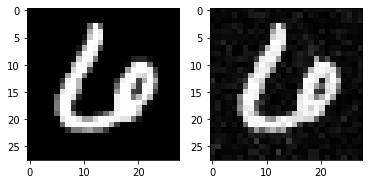

25  :  -0.23806712799207966 25
50  :  0.04550037325812473 25
75  :  0.01815543347727533 25
100  :  -0.0030356245484739475 25
125  :  0.06321645083485927 25
150  :  0.1804765095840839 25
175  :  0.1804765095840839 25
200  :  0.1804765095840839 25
225  :  0.23888886631015616 25
250  :  0.2741596313929414 25
275  :  0.2741596313929414 25
300  :  0.305336056251698 25
325  :  0.3115488770543801 25
350  :  0.3257375601440949 25
375  :  0.33104052821277014 25
400  :  0.33511637381747 25
425  :  0.34073517946771453 25
450  :  0.3513832290907654 25
475  :  0.3513832290907654 25
500  :  0.36796970042300464 25
525  :  0.37377775619468384 25
550  :  0.3745692366238185 25
575  :  0.3745692366238185 25
600  :  0.3745692366238185 25
625  :  0.3745692366238185 25
650  :  0.3882386304027755 25
675  :  0.3882386304027755 25
700  :  0.3882386304027755 25
725  :  0.3882386304027755 25
750  :  0.3903387983680242 25
775  :  0.39157493966667467 25
800  :  0.39394543838084217 25
825  :  0.39394543838084217 25

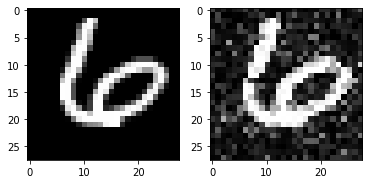

25  :  -0.33106536243937823 25
50  :  0.11890018454827156 25
75  :  -0.8869403486341094 25
100  :  -0.8839918790240475 25
125  :  -0.3895527247805231 25
150  :  -0.5040983432352439 25
175  :  -0.8839918790240475 25
200  :  -0.8767733862141318 25
225  :  -0.8767733862141318 25
250  :  -0.8701354100936615 25
275  :  -0.869903817303525 25
300  :  -0.869903817303525 25
325  :  -0.869903817303525 25
350  :  -0.8676702696661064 25
375  :  -0.867598131841517 25
400  :  -0.8665727751112285 25
425  :  -0.8665727751112285 25
450  :  -0.8655667258780613 25
475  :  -0.8651795586040167 25
500  :  -0.864262955478501 25
525  :  -0.864262955478501 25
550  :  -0.8639579051513984 25
575  :  -0.8631621041022979 25
600  :  -0.8628167368215697 25
625  :  -0.8625016899920793 25
650  :  -0.8621426553670154 25
675  :  -0.8619605346229618 25
700  :  -0.8619602808361783 25
725  :  -0.8612660743810524 25
750  :  -0.8612580069279997 25
775  :  -0.8608109246555753 25
800  :  -0.8607027843857151 25
825  :  -0.86070

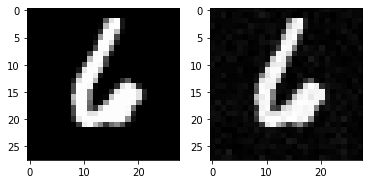

25  :  0.1763315136511947 25
50  :  0.2535388084407214 25
75  :  0.27519330658006586 25
100  :  0.23185622293764513 25
125  :  0.3051673463231014 25
150  :  0.3164180615111164 25
175  :  0.2463445622836345 25
200  :  0.29964410350528614 25
225  :  0.3137172399910415 25
250  :  0.32528383897949775 25
275  :  0.3293207517131559 25
300  :  0.33523280791970145 25
325  :  0.3559587504937708 25
350  :  0.3632855603376326 25
375  :  0.3630536189860446 25
400  :  0.3768145631542418 25
425  :  0.3765769594133115 25
450  :  0.3765769594133115 25
475  :  0.37832988244849775 25
500  :  0.3807210953121112 25
525  :  0.3810350315742502 25
550  :  0.3826411372314276 25
575  :  0.39288882897528105 25
600  :  0.39380142737525414 25
625  :  0.40019967152114555 25
650  :  0.4010688135821088 25
675  :  0.4010688135821088 25
700  :  0.404802427798934 25
725  :  0.40492401522987936 25
750  :  0.40492401522987936 25
775  :  0.4064535260956827 25
800  :  0.4083863979237033 25
825  :  0.41005278727876776 25
85

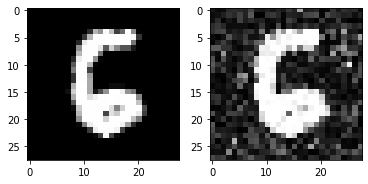

25  :  0.14884016192553762 25
50  :  0.14884016192553762 25
75  :  0.061578036085893184 25
100  :  0.08965534661451513 25
125  :  0.09665846782691279 25
150  :  0.18919734562989554 25
175  :  0.08818555371399384 25
200  :  0.21645147866124448 25
225  :  0.23721961775337153 25
250  :  0.24051613535510208 25
275  :  0.2567758057553752 25
300  :  0.2605644931108725 25
325  :  0.2635818298605688 25
350  :  0.26771648682498084 25
375  :  0.27742944498142463 25
400  :  0.27914454398237826 25
425  :  0.27914454398237826 25
450  :  0.2831687472604618 25
475  :  0.2875264045017237 25
500  :  0.29928542345138853 25
525  :  0.3003693191163142 25
550  :  0.30866826824754773 25
575  :  0.311028043584129 25
600  :  0.3120539764004291 25
625  :  0.3135398108577656 25
650  :  0.3150969140927364 25
675  :  0.3218381615438668 25
700  :  0.3269588330869123 25
725  :  0.33407170594048063 25
750  :  0.3390050075172467 25
775  :  0.3390050075172467 25
800  :  0.34153552302749834 25
825  :  0.344982278527625

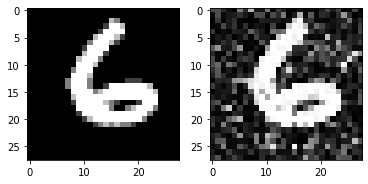

25  :  -0.07297402164963473 25
50  :  -0.07297402164963473 25
75  :  0.07178264470480678 25
100  :  -0.0321719151862484 25
125  :  -9.664510283813321e-05 25
150  :  0.03976116376247496 25
175  :  0.10742792536421786 25
200  :  0.09955634213931619 25
225  :  0.10931676812422841 25
250  :  0.15393581452815508 25
275  :  0.17128606961392434 25
300  :  0.18011601350096706 25
325  :  0.18011601350096706 25
350  :  0.18011601350096706 25
375  :  0.1826957083419618 25
400  :  0.18011601350096706 25
425  :  0.1888346072712479 25
450  :  0.19155517577638514 25
475  :  0.19225476444485834 25
500  :  0.19225476444485834 25
525  :  0.1960939649186928 25
550  :  0.19977226069305343 25
575  :  0.20320183398439862 25
600  :  0.20818765374300474 25
625  :  0.21396925140850898 25
650  :  0.2141084092427855 25
675  :  0.21412787519214216 25
700  :  0.21443194279203615 25
725  :  0.21601163052850159 25
750  :  0.22136702121556917 25
775  :  0.2230576958822449 25
800  :  0.229193832646564 25
825  :  0.231

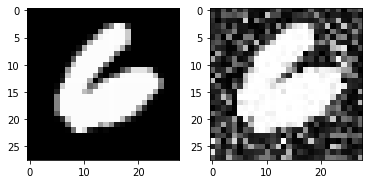

25  :  0.42769558987180945 25
50  :  0.42769558987180945 25
75  :  0.41047996653511415 25
100  :  0.3931262633652873 25
125  :  0.42040419039739063 25
150  :  0.41582991205305964 25
175  :  0.4224493366912025 25
200  :  0.4559329856430082 25
225  :  0.4554819610446753 25
250  :  0.46008959524394183 25
275  :  0.4594915782650654 25
300  :  0.47017725084759326 25
325  :  0.46795363956903646 25
350  :  0.4703006180662097 25
375  :  0.47729206302234123 25
400  :  0.47729206302234123 25
425  :  0.4841418899943298 25
450  :  0.485898021797863 25
475  :  0.49172072301444575 25
500  :  0.4947382891236905 25
525  :  0.5028220026931081 25
550  :  0.5028067366995452 25
575  :  0.5048411144205827 25
600  :  0.5058852234057498 25
625  :  0.506513215222543 25
650  :  0.5083667078017835 25
675  :  0.5091322489369708 25
700  :  0.5097070222646825 25
725  :  0.511710396788944 25
750  :  0.5135691111638874 25
775  :  0.5154349897522655 25
800  :  0.5166318701407497 25
825  :  0.5170515537394896 25
850  

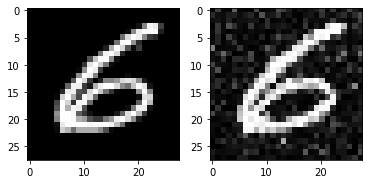

25  :  0.22955205897461006 25
50  :  0.22955205897461006 25
75  :  0.2854198525507308 25
100  :  0.22115545528189662 25
125  :  0.25365446134760755 25
150  :  0.19198635402976855 25
175  :  0.15407978564314195 25
200  :  0.17132427953041063 25
225  :  0.2622368595767154 25
250  :  0.30134451990105005 25
275  :  0.2748825454108812 25
300  :  0.2748825454108812 25
325  :  0.2797554553500329 25
350  :  0.28686485676154455 25
375  :  0.2955419656455684 25
400  :  0.29622071551380674 25
425  :  0.3030685580245722 25
450  :  0.31045702941990283 25
475  :  0.30703316661834923 25
500  :  0.31833858769600776 25
525  :  0.3231628671282205 25
550  :  0.3241414802355793 25
575  :  0.32380536742907073 25
600  :  0.332970524109223 25
625  :  0.336771729435848 25
650  :  0.3367187293158731 25
675  :  0.3367187293158731 25
700  :  0.3367187293158731 25
725  :  0.3367187293158731 25
750  :  0.33681274502693137 25
775  :  0.33899477309551057 25
800  :  0.33899477309551057 25
825  :  0.34004938032236964 

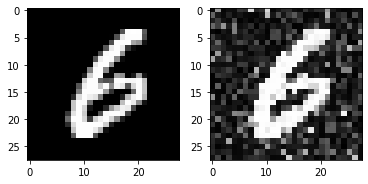

25  :  -0.5336871824157782 25
50  :  -0.05813624233501524 25
75  :  -0.8909385984376996 25
100  :  -0.8851785975565601 25
125  :  -0.8851785975565601 25
150  :  -0.8844928701087936 25
175  :  -0.8839818749205559 25
200  :  -0.8808799485087054 25
225  :  -0.8768564015630487 25
250  :  -0.8768564015630487 25
275  :  -0.8766668631364934 25
300  :  -0.8766668631364934 25
325  :  -0.8729278551057176 25
350  :  -0.8706040987682068 25
375  :  -0.8704326647617066 25
400  :  -0.8704326647617066 25
425  :  -0.8704326647617066 25
450  :  -0.8704326647617066 25
475  :  -0.8698506930824038 25
500  :  -0.8698187970116317 25
525  :  -0.866112958160747 25
550  :  -0.866112958160747 25
575  :  -0.866112958160747 25
600  :  -0.866112958160747 25
625  :  -0.866112958160747 25
650  :  -0.8651275541094142 25
675  :  -0.8651279613360718 25
700  :  -0.8648075519865486 25
725  :  -0.8645288118521912 25
750  :  -0.8643653963595874 25
775  :  -0.864293444213266 25
800  :  -0.864293444213266 25
825  :  -0.864293

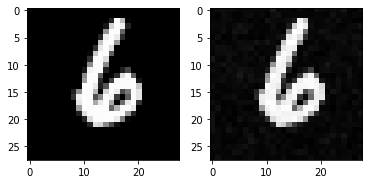

25  :  0.4765828120173763 25
50  :  0.4765828120173763 25
75  :  0.4287395276984392 25
100  :  0.43238100386338313 25
125  :  0.4694828808452102 25
150  :  0.42904556416544176 25
175  :  0.4674379867519922 25
200  :  0.4719199072706716 25
225  :  0.48495547266985223 25
250  :  0.48495547266985223 25
275  :  0.48952976566899314 25
300  :  0.488956283187561 25
325  :  0.488956283187561 25
350  :  0.488956283187561 25
375  :  0.488956283187561 25
400  :  0.4912227440520055 25
425  :  0.4900957742422205 25
450  :  0.4900957742422205 25
475  :  0.4974792047962457 25
500  :  0.4978948295492814 25
525  :  0.5008383098751656 25
550  :  0.5048785682627075 25
575  :  0.5048785682627075 25
600  :  0.5077539362253045 25
625  :  0.507764430894055 25
650  :  0.5078932943283717 25
675  :  0.5088963003305205 25
700  :  0.5103424893229792 25
725  :  0.5118743890030848 25
750  :  0.5132783598963546 25
775  :  0.5173106992708816 25
800  :  0.5182343427243198 25
825  :  0.518213811930103 25
850  :  0.5190

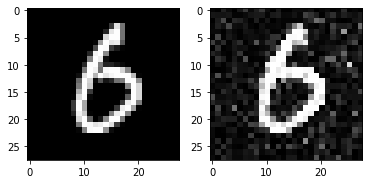

25  :  -0.30204980700858003 25
50  :  -0.010152153579570666 25
75  :  -0.011251542365761202 25
100  :  0.011490959719727356 25
125  :  -0.030904587779993276 25
150  :  -0.030461661577201093 25
175  :  0.045021870125253494 25
200  :  -0.8490011090461007 25
225  :  0.016009923644235702 25
250  :  -0.062183918444983055 25
275  :  0.001494972304079023 25
300  :  0.09792571508687675 25
325  :  0.09623866838622619 25
350  :  0.10993882385805709 25
375  :  0.10993882385805709 25
400  :  0.15349798971972317 25
425  :  0.15021071270790487 25
450  :  0.17545467911308632 25
475  :  0.18759149297595 25
500  :  0.1903837333755526 25
525  :  0.19959567487612984 25
550  :  0.2090157917624056 25
575  :  0.2090157917624056 25
600  :  0.22524278156605582 25
625  :  0.22456059399329875 25
650  :  0.22456059399329875 25
675  :  0.22456059399329875 25
700  :  0.2337100491744628 25
725  :  0.23334248884877518 25
750  :  0.237326250422082 25
775  :  0.23835004570996232 25
800  :  0.24446500365526413 25
825  

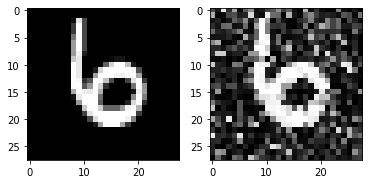

25  :  0.229260253154496 25
50  :  0.29913587641752537 25
75  :  0.20263276369893846 25
100  :  0.20144587164154237 25
125  :  0.18236762366461046 25
150  :  0.16759995347065193 25
175  :  0.17869467109391668 25
200  :  0.20792860629382037 25
225  :  0.21535507577772195 25
250  :  0.21863348176106046 25
275  :  0.23391639522903046 25
300  :  0.23968169774496562 25
325  :  0.2498875846157227 25
350  :  0.2775165177699441 25
375  :  0.281277792420682 25
400  :  0.3061539945619143 25
425  :  0.3146179091702237 25
450  :  0.3146179091702237 25
475  :  0.3146179091702237 25
500  :  0.31909925348312684 25
525  :  0.32286025979460575 25
550  :  0.3251727246282177 25
575  :  0.3251727246282177 25
600  :  0.3297449672318746 25
625  :  0.3337163437915264 25
650  :  0.335820009640663 25
675  :  0.33740867658782453 25
700  :  0.34056263784942553 25
725  :  0.34403770420293256 25
750  :  0.3468741438036861 25
775  :  0.35057624583471814 25
800  :  0.3505276102203388 25
825  :  0.3507006153041441 25

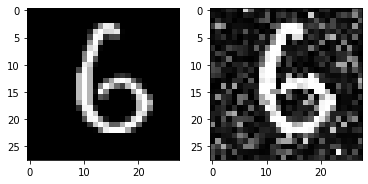

25  :  0.27225366194934253 25
50  :  0.28943781642676497 25
75  :  0.25077426704536143 25
100  :  0.25077426704536143 25
125  :  0.35546502046683337 25
150  :  0.3195321798187595 25
175  :  0.43291649855215447 25
200  :  0.4931327769590006 25
225  :  0.4893019490304293 25
250  :  0.5069081349796061 25
275  :  0.49647566720404757 25
300  :  0.5083092174714907 25
325  :  0.5097768514663632 25
350  :  0.5112879365396239 25
375  :  0.51495198584079 25
400  :  0.5158037832797904 25
425  :  0.5289579935521116 25
450  :  0.5290336009597685 25
475  :  0.5419946146936047 25
500  :  0.5464149247204421 25
525  :  0.5464839603137155 25
550  :  0.5485854238420723 25
575  :  0.5500578155571063 25
600  :  0.5556302657066899 25
625  :  0.5611454369011895 25
650  :  0.5634212460558243 25
675  :  0.5647909957714325 25
700  :  0.5695745251530583 25
725  :  0.5747870795911633 25
750  :  0.5747870795911633 25
775  :  0.5747870795911633 25
800  :  0.575872853850523 25
825  :  0.5778361235814116 25
850  :  0

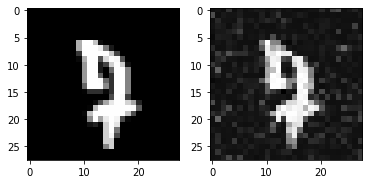

25  :  0.11534674890932947 25
50  :  0.1622484484422073 25
75  :  0.21275160202061777 25
100  :  0.36963539156645664 25
125  :  0.36963539156645664 25
150  :  0.3987448603233147 25
175  :  0.36963539156645664 25
200  :  0.40370406675446774 25
225  :  0.4216554657920295 25
250  :  0.4358296600803332 25
275  :  0.4427969314831609 25
300  :  0.4728159633625907 25
325  :  0.46973827308307803 25
350  :  0.4756707764723681 25
375  :  0.4815433068056968 25
400  :  0.48480022584506854 25
425  :  0.48934946780128186 25
450  :  0.4964385145987916 25
475  :  0.5132257808280241 25
500  :  0.5132257808280241 25
525  :  0.5132257808280241 25
550  :  0.5165218924964436 25
575  :  0.5196545364001492 25
600  :  0.5259185837411517 25
625  :  0.5259323159280047 25
650  :  0.5268499378747629 25
675  :  0.5268955132934372 25
700  :  0.5297484116845859 25
725  :  0.530577014957735 25
750  :  0.530577014957735 25
775  :  0.530577014957735 25
800  :  0.5325507843723691 25
825  :  0.5328748492885172 25
850  : 

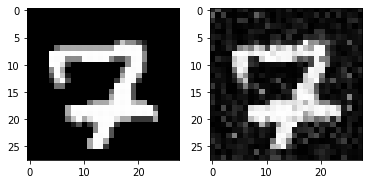

25  :  -0.547166200592504 25
50  :  -0.547166200592504 25
75  :  -0.8648838722610008 25
100  :  -0.855879195114466 25
125  :  -0.8417184352493918 25
150  :  -0.4426572059023168 25
175  :  -0.22438282679615254 25
200  :  0.09488343881038874 25
225  :  0.3794769400449783 25
250  :  0.4026728541228748 25
275  :  0.41020731154586443 25
300  :  0.41020731154586443 25
325  :  0.41020731154586443 25
350  :  0.4166626914332665 25
375  :  0.42302792713826814 25
400  :  0.4234039777743746 25
425  :  0.4272849723059456 25
450  :  0.42743536027167356 25
475  :  0.44049877762223777 25
500  :  0.4407395633799952 25
525  :  0.4407395633799952 25
550  :  0.44590093459888475 25
575  :  0.44731839877449475 25
600  :  0.4484827242516066 25
625  :  0.4498113984925739 25
650  :  0.45327749338211937 25
675  :  0.45382889592434134 25
700  :  0.45876365808280223 25
725  :  0.45876365808280223 25
750  :  0.45988840956037863 25
775  :  0.46249275656364824 25
800  :  0.4629325336589327 25
825  :  0.4632549914127

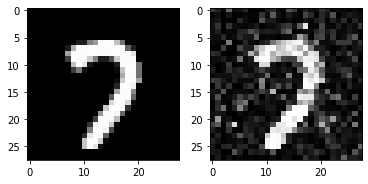

25  :  -0.5969269402434328 25
50  :  -0.5240268936418799 25
75  :  -0.8846794563029757 25
100  :  -0.8846794563029757 25
125  :  -0.8842248157571897 25
150  :  -0.8842248157571897 25
175  :  -0.8834349679746252 25
200  :  -0.8816100949329364 25
225  :  -0.8808644764787509 25
250  :  -0.8799953675568478 25
275  :  -0.8769728005823274 25
300  :  -0.8756245389196614 25
325  :  -0.8724358385896451 25
350  :  -0.8708349245590032 25
375  :  -0.8708349245590032 25
400  :  -0.8708349245590032 25
425  :  -0.868759335899558 25
450  :  -0.8667532870636949 25
475  :  -0.8667532870636949 25
500  :  -0.866026172090818 25
525  :  -0.8658524167668994 25
550  :  -0.8655010301260884 25
575  :  -0.8651233831970236 25
600  :  -0.8639504967995674 25
625  :  -0.8638063902515754 25
650  :  -0.8634872288715814 25
675  :  -0.8634064264222772 25
700  :  -0.862975936799418 25
725  :  -0.8627512134327833 25
750  :  -0.8623494102437202 25
775  :  -0.8623494102437202 25
800  :  -0.8620943553655747 25
825  :  -0.862

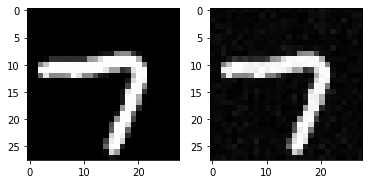

25  :  -0.8856885701973383 25
50  :  -0.8842563365755023 25
75  :  -0.8842563365755023 25
100  :  -0.8824314389328322 25
125  :  -0.8803409179356884 25
150  :  -0.8716912961848448 25
175  :  -0.8704997609029179 25
200  :  -0.8703897826672475 25
225  :  -0.8703897826672475 25
250  :  -0.8703897826672475 25
275  :  -0.8698118372665261 25
300  :  -0.8671551059959103 25
325  :  -0.866121329044018 25
350  :  -0.866121329044018 25
375  :  -0.8649114126031456 25
400  :  -0.8641819807405408 25
425  :  -0.861238389421091 25
450  :  -0.861238389421091 25
475  :  -0.861238389421091 25
500  :  -0.861238389421091 25
525  :  -0.861238389421091 25
550  :  -0.861238389421091 25
575  :  -0.861238389421091 25
600  :  -0.861238389421091 25
625  :  -0.8608457046655072 25
650  :  -0.8606331024887909 25
675  :  -0.8606331024887909 25
700  :  -0.8600358640459975 25
725  :  -0.8600038153728838 25
750  :  -0.8599809239537134 25
775  :  -0.8597072357124178 25
800  :  -0.8595702825930314 25
Time:  88.47403764724

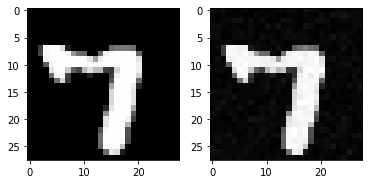

25  :  0.372425983408862 25
50  :  0.41411921644989946 25
75  :  0.3886733910542295 25
100  :  0.39592085777637653 25
125  :  0.40874654493114 25
150  :  0.44114891248625077 25
175  :  0.4253599787590343 25
200  :  0.4253599787590343 25
225  :  0.4501619957264946 25
250  :  0.4847623564492535 25
275  :  0.5024908513322406 25
300  :  0.4903389599271237 25
325  :  0.5066064444696263 25
350  :  0.5060854623749372 25
375  :  0.5285598076881055 25
400  :  0.5283830298810035 25
425  :  0.5713752048775104 25
450  :  0.570446641128554 25
475  :  0.570446641128554 25
500  :  0.570446641128554 25
525  :  0.5752962042543511 25
550  :  0.573862102075164 25
575  :  0.5771487958106154 25
600  :  0.5771366928868394 25
625  :  0.5810055682836974 25
650  :  0.5810055682836974 25
675  :  0.5810055682836974 25
700  :  0.5823316968749619 25
725  :  0.5819614371966522 25
750  :  0.5835935842950053 25
775  :  0.5839244791974494 25
800  :  0.5880904537087278 25
825  :  0.5885497083650054 25
850  :  0.5944924

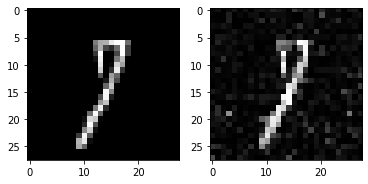

25  :  0.26238983525906945 25
50  :  0.26238983525906945 25
75  :  0.507723048980091 25
100  :  0.507723048980091 25
125  :  0.5274721449576881 25
150  :  0.5307362771727024 25
175  :  0.5404498312113565 25
200  :  0.5404498312113565 25
225  :  0.5404498312113565 25
250  :  0.5467816226892119 25
275  :  0.5468442685838636 25
300  :  0.5542994023981969 25
325  :  0.5633544796511969 25
350  :  0.5633160145170824 25
375  :  0.5633160145170824 25
400  :  0.5633160145170824 25
425  :  0.5637662128526235 25
450  :  0.5715922992071375 25
475  :  0.5715981277675339 25
500  :  0.5715981277675339 25
525  :  0.5788398286360339 25
550  :  0.5788398286360339 25
575  :  0.5799611558444967 25
600  :  0.5811714548252521 25
625  :  0.5811714548252521 25
650  :  0.5811714548252521 25
675  :  0.5811714548252521 25
700  :  0.5836233650539353 25
725  :  0.5867806380358567 25
750  :  0.5888434327930387 25
775  :  0.5900338998809252 25
800  :  0.5946652670438577 25
825  :  0.5968732277952288 25
850  :  0.596

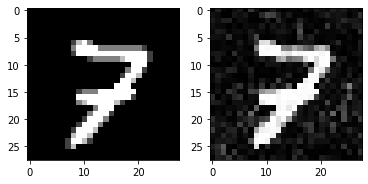

25  :  -0.5017028880110587 25
50  :  -0.3287229948490066 25
75  :  -0.12574985012950096 25
100  :  -0.0954072116274407 25
125  :  0.15993412176391342 25
150  :  0.1618422209312561 25
175  :  0.1863568784619838 25
200  :  0.21375009336364426 25
225  :  0.2146780638435124 25
250  :  0.2146780638435124 25
275  :  0.24727171124223157 25
300  :  0.24173702702676036 25
325  :  0.24173702702676036 25
350  :  0.2596764252290238 25
375  :  0.2634313641974442 25
400  :  0.2652988738404719 25
425  :  0.269118960589527 25
450  :  0.2819385185278935 25
475  :  0.28565507322939165 25
500  :  0.2869440564824308 25
525  :  0.2883812996245892 25
550  :  0.3043516353062124 25
575  :  0.3047564423965936 25
600  :  0.3123051915103396 25
625  :  0.31600415808411314 25
650  :  0.3188244053380435 25
675  :  0.32183061288376497 25
700  :  0.32190331234356184 25
725  :  0.3247832486787812 25
750  :  0.3253919474166807 25
775  :  0.32743496951746115 25
800  :  0.3274451604526799 25
825  :  0.3303645746914048 25

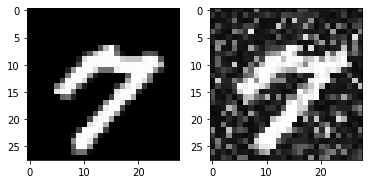

25  :  -0.890710567410151 25
50  :  -0.8875478333811231 25
75  :  -0.8814514847098933 25
100  :  -0.879685585367804 25
125  :  -0.879641704081425 25
150  :  -0.876435582768576 25
175  :  -0.8723640878791571 25
200  :  -0.8723640878791571 25
225  :  -0.8723640878791571 25
250  :  -0.8723640878791571 25
275  :  -0.8681922373584032 25
300  :  -0.8681922373584032 25
325  :  -0.8681922373584032 25
350  :  -0.8681922373584032 25
375  :  -0.8677781142186787 25
400  :  -0.8667444542279393 25
425  :  -0.8654483234189383 25
450  :  -0.865353601915109 25
475  :  -0.865353601915109 25
500  :  -0.8645062113872358 25
525  :  -0.8639471951479993 25
550  :  -0.8639471951479993 25
575  :  -0.8639471951479993 25
600  :  -0.8634049002283793 25
625  :  -0.8629713723554676 25
650  :  -0.8629537505205459 25
675  :  -0.862762241862596 25
700  :  -0.862731345541728 25
725  :  -0.8626040930312437 25
750  :  -0.8624349331331931 25
775  :  -0.862286906474146 25
800  :  -0.8622610551657551 25
Time:  95.5897929668

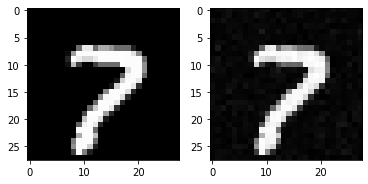

25  :  -0.8863448583482155 25
50  :  -0.8827131975106242 25
75  :  -0.8812793504146332 25
100  :  -0.8811186793520582 25
125  :  -0.8743057705725574 25
150  :  -0.8666616386487621 25
175  :  -0.8666616386487621 25
200  :  -0.8666616386487621 25
225  :  -0.8666616386487621 25
250  :  -0.866495788512531 25
275  :  -0.8659551710727081 25
300  :  -0.8659407347946761 25
325  :  -0.8655989308550527 25
350  :  -0.8654355099206874 25
375  :  -0.8652964493820239 25
400  :  -0.8605996974650203 25
425  :  -0.8606006791327797 25
450  :  -0.8606006791327797 25
475  :  -0.8606006791327797 25
500  :  -0.860151041012315 25
525  :  -0.859485514800855 25
550  :  -0.859485514800855 25
575  :  -0.8594439067728299 25
600  :  -0.858809703402118 25
625  :  -0.8581667629000893 25
650  :  -0.8581153643716978 25
675  :  -0.8581153544419257 25
700  :  -0.8581153544419257 25
725  :  -0.8581153544419257 25
750  :  -0.8580633615733614 25
775  :  -0.8579494289269649 25
800  :  -0.8579029357881482 25
Time:  92.409974

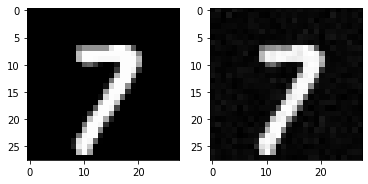

25  :  -0.7330675692306498 25
50  :  -0.345943976801058 25
75  :  -0.369413655006119 25
100  :  0.12133378277457563 25
125  :  0.0752946778480637 25
150  :  0.3867721895639695 25
175  :  0.396235297860375 25
200  :  0.3971089310441109 25
225  :  0.4239142656917614 25
250  :  0.4294153486718828 25
275  :  0.4294153486718828 25
300  :  0.4296039388809141 25
325  :  0.4462037392950441 25
350  :  0.44923484896909055 25
375  :  0.4555995310294891 25
400  :  0.46838379740109204 25
425  :  0.4705249639600273 25
450  :  0.47092560295285707 25
475  :  0.47092560295285707 25
500  :  0.47647209504863997 25
525  :  0.48489704369017944 25
550  :  0.48936044948051616 25
575  :  0.4891036245872409 25
600  :  0.4909276665837947 25
625  :  0.4909276665837947 25
650  :  0.49125772331885337 25
675  :  0.4945169020594752 25
700  :  0.49540886451420046 25
725  :  0.4956321587752148 25
750  :  0.49724816200359845 25
775  :  0.5004136691950516 25
800  :  0.5004136691950516 25
825  :  0.5008481234642681 25
85

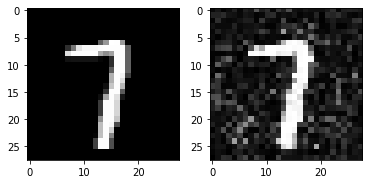

25  :  -0.8937907194225334 25
50  :  -0.8843831238587001 25
75  :  -0.8843831238587001 25
100  :  -0.877686383169215 25
125  :  -0.8753674517542814 25
150  :  -0.8753674517542814 25
175  :  -0.8737205318099052 25
200  :  -0.8716957417944237 25
225  :  -0.871686277213268 25
250  :  -0.8667802712985591 25
275  :  -0.8658809539308746 25
300  :  -0.8658809539308746 25
325  :  -0.8658573728590597 25
350  :  -0.8658044170918356 25
375  :  -0.8652267792517081 25
400  :  -0.8635285673795476 25
425  :  -0.8623963251425332 25
450  :  -0.8620821764432837 25
475  :  -0.8615558633270839 25
500  :  -0.8615558633270839 25
525  :  -0.8615558633270839 25
550  :  -0.861446603389111 25
575  :  -0.861446603389111 25
600  :  -0.8614452896165324 25
625  :  -0.8614452896165324 25
650  :  -0.8613511595251768 25
675  :  -0.8608854744905143 25
700  :  -0.8608854744905143 25
725  :  -0.8608854744905143 25
750  :  -0.86062745563615 25
775  :  -0.86062745563615 25
800  :  -0.86062745563615 25
Time:  92.08822560310

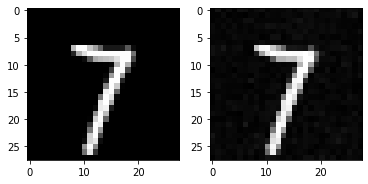

25  :  -0.587281638684325 25
50  :  -0.4906612789714267 25
75  :  0.036932222555062955 25
100  :  0.27834292062914673 25
125  :  0.3253651267831141 25
150  :  0.385838572383718 25
175  :  0.40776917147924874 25
200  :  0.41017789995822657 25
225  :  0.4192978861715829 25
250  :  0.4261582726065289 25
275  :  0.4402989916590569 25
300  :  0.4454176924107358 25
325  :  0.4578767479818913 25
350  :  0.45802037946995566 25
375  :  0.45802037946995566 25
400  :  0.45802037946995566 25
425  :  0.45802037946995566 25
450  :  0.46468818998765254 25
475  :  0.464820887764967 25
500  :  0.464820887764967 25
525  :  0.4700937361442468 25
550  :  0.4731250293580291 25
575  :  0.4740103609128058 25
600  :  0.4740103609128058 25
625  :  0.4747600361460897 25
650  :  0.47634286760218136 25
675  :  0.47645290373296856 25
700  :  0.47746914842755406 25
725  :  0.48031917582119776 25
750  :  0.4814957387532353 25
775  :  0.4814957387532353 25
800  :  0.4825787283696944 25
825  :  0.482545603819606 25
85

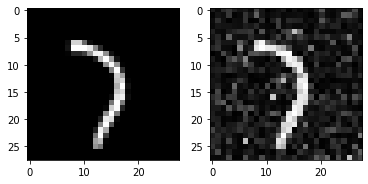

25  :  -0.8570804125028302 25
50  :  0.22787676592272166 25
75  :  0.18219114681391524 25
100  :  -0.48351527938106587 25
125  :  -0.8272260003184356 25
150  :  -0.6875980126474013 25
175  :  -0.8853504412383844 25
200  :  -0.8841686217140724 25
225  :  -0.8841870970431185 25
250  :  -0.8800315290030437 25
275  :  -0.8768335553611014 25
300  :  -0.8768484307649222 25
325  :  -0.8728918107797622 25
350  :  -0.8728918107797622 25
375  :  -0.8728918107797622 25
400  :  -0.8723252751059984 25
425  :  -0.8705213889487868 25
450  :  -0.8705213889487868 25
475  :  -0.8696681567628362 25
500  :  -0.8696681567628362 25
525  :  -0.8696681567628362 25
550  :  -0.8685336177315436 25
575  :  -0.8685336177315436 25
600  :  -0.8685215084677811 25
625  :  -0.8676960769286582 25
650  :  -0.8676960769286582 25
675  :  -0.8674081113953126 25
700  :  -0.8672107482340332 25
725  :  -0.8668071467389462 25
750  :  -0.8668071467389462 25
775  :  -0.8665597674578687 25
800  :  -0.8665070778633265 25
825  :  -0

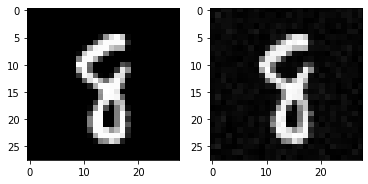

25  :  -0.8801479830684559 25
50  :  -0.790566210648257 25
75  :  -0.44051653330022583 25
100  :  -0.8757625152771118 25
125  :  -0.328419773269393 25
150  :  -0.8753912348902377 25
175  :  -0.8737422700845962 25
200  :  -0.8735461279933862 25
225  :  -0.8735461279933862 25
250  :  -0.8735461279933862 25
275  :  -0.873185366491809 25
300  :  -0.873185366491809 25
325  :  -0.873185366491809 25
350  :  -0.873185366491809 25
375  :  -0.873185366491809 25
400  :  -0.873185366491809 25
425  :  -0.873185366491809 25
450  :  -0.8691728576672214 25
475  :  -0.8691728576672214 25
500  :  -0.8691728576672214 25
525  :  -0.8690118922108984 25
550  :  -0.8674520231873264 25
575  :  -0.8671230566056523 25
600  :  -0.8671230566056523 25
625  :  -0.8671230566056523 25
650  :  -0.8671230566056523 25
675  :  -0.865078666886401 25
700  :  -0.8650750396768112 25
725  :  -0.8650750396768112 25
750  :  -0.8649779375027625 25
775  :  -0.8637774010233965 25
800  :  -0.8637772636387641 25
825  :  -0.862635698

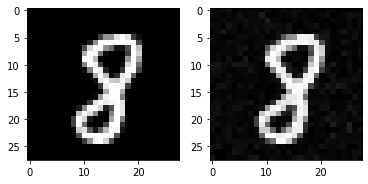

25  :  -0.15098977235904215 25
50  :  0.1269353173981692 25
75  :  0.04196232320100712 25
100  :  0.03437139112626719 25
125  :  -0.8901036840566823 25
150  :  -0.4053237521041784 25
175  :  -0.8901036840566823 25
200  :  -0.8901036840566823 25
225  :  -0.8901036840566823 25
250  :  -0.8901036840566823 25
275  :  -0.8901036840566823 25
300  :  -0.8861630426544839 25
325  :  -0.8830223676550956 25
350  :  -0.8830223676550956 25
375  :  -0.8773708620687014 25
400  :  -0.8773440570229017 25
425  :  -0.8772229304755174 25
450  :  -0.8743474845058432 25
475  :  -0.8732203480651307 25
500  :  -0.8723409927773385 25
525  :  -0.8723409927773385 25
550  :  -0.8704328972043749 25
575  :  -0.8704328972043749 25
600  :  -0.8704328972043749 25
625  :  -0.8704328972043749 25
650  :  -0.8704328972043749 25
675  :  -0.8698850498312711 25
700  :  -0.8695262092070233 25
725  :  -0.8695252704061197 25
750  :  -0.869312872572575 25
775  :  -0.8692612240403197 25
800  :  -0.8691366258149376 25
825  :  -0.8

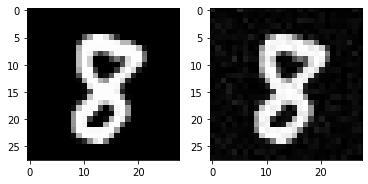

25  :  0.1832514326012945 25
50  :  0.2652045449664362 25
75  :  0.22512726412977446 25
100  :  0.22910667334948892 25
125  :  -0.5931671109680068 25
150  :  0.05153713674003424 25
175  :  0.11373134453262146 25
200  :  0.24066702474857204 25
225  :  -0.912503485179243 25
250  :  0.1397316057069934 25
275  :  0.08894239176178081 25
300  :  -0.9112534411694997 25
325  :  -0.9007588107604793 25
350  :  0.2179569957881783 25
375  :  -0.8997982318863665 25
400  :  -0.8997982318863665 25
425  :  -0.8997982318863665 25
450  :  -0.8988407661954221 25
475  :  -0.8930451737195721 25
500  :  -0.8920844480880394 25
525  :  -0.8920851528565725 25
550  :  -0.8908585621221528 25
575  :  -0.8880760709771156 25
600  :  -0.8870415607069104 25
625  :  -0.8870415591974333 25
650  :  -0.8870415591974333 25
675  :  -0.8869942395975596 25
700  :  -0.8869942395975596 25
725  :  -0.8868111536601961 25
750  :  -0.8861520961971061 25
775  :  -0.8851581090421956 25
800  :  -0.8848820558379082 25
825  :  -0.88488

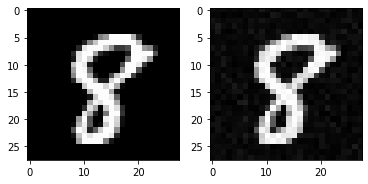

25  :  0.21272335533058478 25
50  :  0.21272335533058478 25
75  :  0.19548844570715995 25
100  :  0.201324719742225 25
125  :  0.1813684642997111 25
150  :  0.11900595005415704 25
175  :  0.12719969600980408 25
200  :  0.09080219287890745 25
225  :  0.10078239265663591 25
250  :  0.14203045141311577 25
275  :  0.18154219400487714 25
300  :  0.17401761692868722 25
325  :  0.16859630035828532 25
350  :  0.19574663420052274 25
375  :  0.19574663420052274 25
400  :  0.20463749868925074 25
425  :  0.20990970590107338 25
450  :  0.20986507822826883 25
475  :  0.21597993028233087 25
500  :  0.21750681530494198 25
525  :  0.22054683741482217 25
550  :  0.224534823589019 25
575  :  0.22427953101539844 25
600  :  0.2277480174526505 25
625  :  0.2290405499456838 25
650  :  0.2299035827317084 25
675  :  0.23235678192480846 25
700  :  0.23609951661788953 25
725  :  0.24128053055002663 25
750  :  0.24417729831263646 25
775  :  0.2476129041625723 25
800  :  0.2500087372676323 25
825  :  0.25462975344

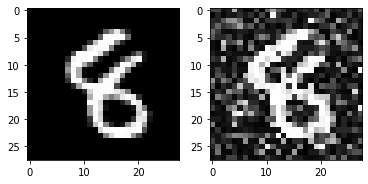

25  :  0.2178227634855444 25
50  :  0.2178227634855444 25
75  :  0.20811562214629709 25
100  :  0.17849084581294805 25
125  :  0.07416926466148244 25
150  :  0.07632388477734453 25
175  :  0.08700338467212432 25
200  :  0.16245881538736728 25
225  :  0.19539293273887265 25
250  :  0.2069014511491461 25
275  :  0.22115758561815885 25
300  :  0.22889374000298868 25
325  :  0.2255828068359938 25
350  :  0.2728687994629993 25
375  :  0.29043615084187296 25
400  :  0.2891546523557388 25
425  :  0.3010219009344654 25
450  :  0.3082355809931465 25
475  :  0.31023301442537093 25
500  :  0.33493798936396324 25
525  :  0.3351460243499283 25
550  :  0.33530567755977897 25
575  :  0.3404088543299459 25
600  :  0.3663474567426124 25
625  :  0.36793554860369837 25
650  :  0.36793554860369837 25
675  :  0.3751802174272615 25
700  :  0.37522415301747125 25
725  :  0.37549979021212593 25
750  :  0.3784092441350557 25
775  :  0.37916390299023833 25
800  :  0.3838198677607024 25
825  :  0.384904337582583

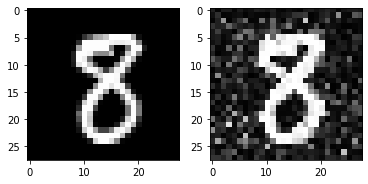

25  :  0.046010315138168556 25
50  :  0.12998006878889218 25
75  :  0.10618734276576103 25
100  :  0.051860879657967374 25
125  :  0.10932971487429444 25
150  :  0.09903860066312087 25
175  :  0.04502621309211319 25
200  :  -0.050025370250967816 25
225  :  -0.0027773327637807266 25
250  :  0.052736740979781316 25
275  :  0.0837797587897382 25
300  :  0.1562580799144444 25
325  :  0.1988430090878407 25
350  :  0.1988430090878407 25
375  :  0.1988430090878407 25
400  :  0.20860225613084077 25
425  :  0.23265068976201114 25
450  :  0.24278295936422578 25
475  :  0.24197902800599613 25
500  :  0.24197902800599613 25
525  :  0.24197902800599613 25
550  :  0.2614951358911077 25
575  :  0.25796814140635344 25
600  :  0.25796814140635344 25
625  :  0.26872257128476745 25
650  :  0.2677804647424349 25
675  :  0.2804133811581181 25
700  :  0.27872261330412795 25
725  :  0.2844810268091772 25
750  :  0.29921978458338455 25
775  :  0.3019287732349233 25
800  :  0.30574762520465093 25
825  :  0.310

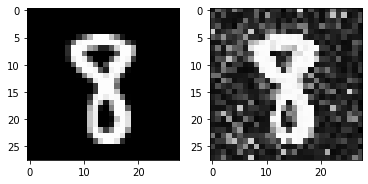

25  :  -0.29297048531261816 25
50  :  -0.07976702341039399 25
75  :  -0.24710481316891886 25
100  :  -0.22127990853568524 25
125  :  -0.27261632796609603 25
150  :  -0.2005268098635718 25
175  :  -0.18761656777937608 25
200  :  -0.1543835485573401 25
225  :  -0.01591505306381269 25
250  :  0.06314282139180821 25
275  :  -0.010035532060438501 25
300  :  0.07940071988386915 25
325  :  0.12721293313053816 25
350  :  0.11648562980565297 25
375  :  0.13674723147631662 25
400  :  0.13944136975513077 25
425  :  0.15522580016651671 25
450  :  0.1852398272656916 25
475  :  0.19891818760072377 25
500  :  0.200130907503272 25
525  :  0.19550383191288395 25
550  :  0.20346842832882467 25
575  :  0.21990571969058204 25
600  :  0.22667419543709022 25
625  :  0.22894604813169278 25
650  :  0.2427885649312228 25
675  :  0.27196509475590847 25
700  :  0.27196509475590847 25
725  :  0.27196509475590847 25
750  :  0.27196509475590847 25
775  :  0.27196509475590847 25
800  :  0.27998348462641137 25
825  :

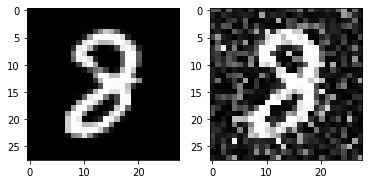

25  :  0.4188063756661333 25
50  :  0.4188063756661333 25
75  :  0.34251920203171765 25
100  :  0.2661032357528178 25
125  :  0.2833884190031178 25
150  :  0.26674846700411226 25
175  :  0.28100281097160446 25
200  :  0.30195929447936937 25
225  :  0.337726612354426 25
250  :  0.33373031343335247 25
275  :  0.3375229368341553 25
300  :  0.33659864684310775 25
325  :  0.3379837771791801 25
350  :  0.3456241812170716 25
375  :  0.3500231136693749 25
400  :  0.3579868593971232 25
425  :  0.36462748588863836 25
450  :  0.3632846160182477 25
475  :  0.36220756354199285 25
500  :  0.3674306579080935 25
525  :  0.3680570440428427 25
550  :  0.37715949033889834 25
575  :  0.3804831034614957 25
600  :  0.3835926581715324 25
625  :  0.38230708448181777 25
650  :  0.38230708448181777 25
675  :  0.3833550518826256 25
700  :  0.38493177578909576 25
725  :  0.385766778614038 25
750  :  0.3858309896860467 25
775  :  0.3875030904609066 25
800  :  0.3890245990085215 25
825  :  0.3890337543506639 25
850

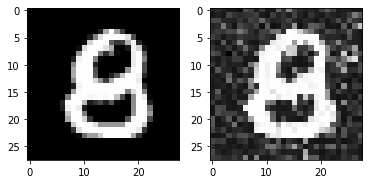

25  :  -0.11495454826194951 25
50  :  -0.022117968922105824 25
75  :  0.03261550444270489 25
100  :  0.039559187136660845 25
125  :  -0.8810492085318807 25
150  :  -0.03936757963086268 25
175  :  -0.7469350613529715 25
200  :  -0.8810492085318807 25
225  :  -0.8798670174553999 25
250  :  -0.8798670174553999 25
275  :  -0.8798670174553999 25
300  :  -0.8785226734608997 25
325  :  -0.8785226734608997 25
350  :  -0.8785226734608997 25
375  :  -0.8785226734608997 25
400  :  -0.8769044875003533 25
425  :  -0.8769044875003533 25
450  :  -0.8767318054851638 25
475  :  -0.8760001584866984 25
500  :  -0.8750009217283636 25
525  :  -0.8717040137414643 25
550  :  -0.8717040137414643 25
575  :  -0.8717040137414643 25
600  :  -0.8717040137414643 25
625  :  -0.8717040137414643 25
650  :  -0.871303840429158 25
675  :  -0.8712027872379117 25
700  :  -0.8702819253359639 25
725  :  -0.8700615950974736 25
750  :  -0.8692874663781646 25
775  :  -0.8692874663781646 25
800  :  -0.8692874663781646 25
825  : 

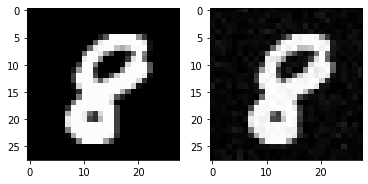

25  :  0.25966797351140825 25
50  :  0.29193054102138327 25
75  :  0.21566001293115106 25
100  :  0.23056580567409946 25
125  :  0.1935516068798624 25
150  :  0.18588952095491013 25
175  :  0.17528888315419033 25
200  :  0.1834123846406398 25
225  :  0.17492789275291853 25
250  :  0.2165296664448425 25
275  :  0.21687943823448075 25
300  :  0.23635011715692877 25
325  :  0.23635011715692877 25
350  :  0.23635011715692877 25
375  :  0.24066120075557462 25
400  :  0.2498823505535972 25
425  :  0.2528635958347213 25
450  :  0.25801448960948503 25
475  :  0.25978797094977485 25
500  :  0.25982264170917035 25
525  :  0.266842477407071 25
550  :  0.27048022069208444 25
575  :  0.27083911070580313 25
600  :  0.27723366694738355 25
625  :  0.28288979446063767 25
650  :  0.28288979446063767 25
675  :  0.2875954558231738 25
700  :  0.2875954558231738 25
725  :  0.2901274238407105 25
750  :  0.29019054949623285 25
775  :  0.2917527702262169 25
800  :  0.2948805915888527 25
825  :  0.2948805915888

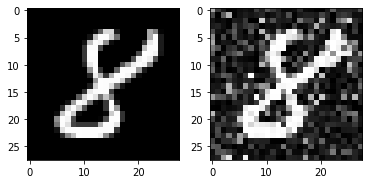

25  :  0.08043168017200364 25
50  :  0.24412667466079302 25
75  :  0.24729725804377106 25
100  :  0.23663250083460563 25
125  :  0.1666977201904583 25
150  :  0.18471557902294566 25
175  :  0.186025312173985 25
200  :  0.1996192337219509 25
225  :  0.033250181722860817 25
250  :  0.15344782426928927 25
275  :  -0.9147061303728454 25
300  :  -0.9109162801617441 25
325  :  -0.9083030409947014 25
350  :  -0.8237650261812806 25
375  :  -0.9040847008690747 25
400  :  -0.8824936528958195 25
425  :  -0.7863685326942791 25
450  :  -0.8281456410299698 25
475  :  -0.8902774961079079 25
500  :  -0.8902774961079079 25
525  :  -0.8056617139922968 25
550  :  -0.8856300759492581 25
575  :  -0.8844894236024031 25
600  :  -0.88374246986313 25
625  :  -0.8832329179732695 25
650  :  -0.8832329179732695 25
675  :  -0.8828191738059464 25
700  :  -0.8828306892985196 25
725  :  -0.8823433237341173 25
750  :  -0.8824024000410113 25
775  :  -0.8822876762251053 25
800  :  -0.8822876762251053 25
825  :  -0.88218

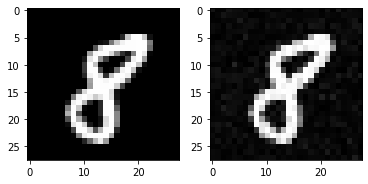

25  :  -0.5923490061677644 25
50  :  -0.5608443841652018 25
75  :  -0.5774553589037028 25
100  :  -0.4000094117337126 25
125  :  -0.3502308944721326 25
150  :  -0.30666236299371347 25
175  :  -0.24781829167935715 25
200  :  -0.09365257807622729 25
225  :  0.15794391984103645 25
250  :  0.2617647286988522 25
275  :  0.21903317153049412 25
300  :  0.37999443827297835 25
325  :  0.36490956774881866 25
350  :  0.3445081359915039 25
375  :  0.3445081359915039 25
400  :  0.3445081359915039 25
425  :  0.3445081359915039 25
450  :  0.35823882529061224 25
475  :  0.3855146196670861 25
500  :  0.4086958191413443 25
525  :  0.42197922564851165 25
550  :  0.4202019161164469 25
575  :  0.4296421494632308 25
600  :  0.42988368302237046 25
625  :  0.4297930492545161 25
650  :  0.45157097416684894 25
675  :  0.4553932464514317 25
700  :  0.4541799478415341 25
725  :  0.4564779895244158 25
750  :  0.4716078743200768 25
775  :  0.4709747519018646 25
800  :  0.47888145002215216 25
825  :  0.4788814500221

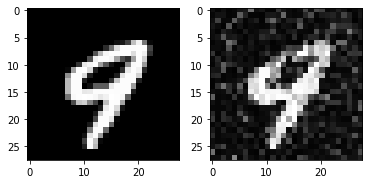

25  :  -0.881909746696079 25
50  :  -0.8791466965436023 25
75  :  -0.8769451978778415 25
100  :  -0.8755249066402455 25
125  :  -0.8730945351857182 25
150  :  -0.8711319085704796 25
175  :  -0.8708482926216204 25
200  :  -0.8615800846376731 25
225  :  -0.8615807948393271 25
250  :  -0.8615807948393271 25
275  :  -0.8615807948393271 25
300  :  -0.8615807948393271 25
325  :  -0.8615807948393271 25
350  :  -0.8612107323695123 25
375  :  -0.8605565114216428 25
400  :  -0.8605565114216428 25
425  :  -0.8596074823020811 25
450  :  -0.8592121217240962 25
475  :  -0.8592004819317656 25
500  :  -0.8576120917150809 25
525  :  -0.8574549552129597 25
550  :  -0.8573594636789137 25
575  :  -0.8566461595132588 25
600  :  -0.8566461595132588 25
625  :  -0.8566461595132588 25
650  :  -0.8565398088577657 25
675  :  -0.8565398088577657 25
700  :  -0.8565021181138592 25
725  :  -0.8563198691068835 25
750  :  -0.856151070106088 25
775  :  -0.8561511177349846 25
800  :  -0.8554355914920541 25
Time:  96.809

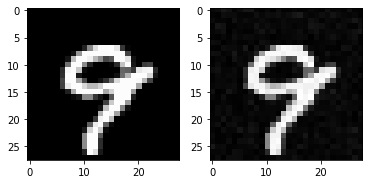

25  :  0.036256497272794785 25
50  :  0.2567939053299204 25
75  :  0.14522977791526603 25
100  :  0.2341506719235656 25
125  :  0.23147530814912542 25
150  :  0.21770565672985098 25
175  :  0.21992144024639015 25
200  :  0.29532083778692403 25
225  :  0.2936387835927134 25
250  :  0.3024264682223064 25
275  :  0.3179413609197425 25
300  :  0.31250875127671585 25
325  :  0.3155408333889966 25
350  :  0.3155408333889966 25
375  :  0.3362296483234841 25
400  :  0.33597129616373667 25
425  :  0.34912719003891507 25
450  :  0.3517884771991621 25
475  :  0.35516915651146663 25
500  :  0.35516915651146663 25
525  :  0.36108527165246834 25
550  :  0.3627666246098479 25
575  :  0.36675177121120617 25
600  :  0.3692152344616681 25
625  :  0.3723982630538485 25
650  :  0.38029930546737334 25
675  :  0.38471548237177 25
700  :  0.38501043715266453 25
725  :  0.39647426086210463 25
750  :  0.39708455408761995 25
775  :  0.39955071325421726 25
800  :  0.40012783187289885 25
825  :  0.403016892166850

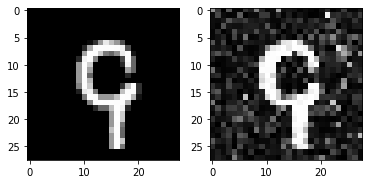

25  :  -0.5276961459641537 25
50  :  -0.5017255851018203 25
75  :  -0.42423932747324544 25
100  :  -0.3197682930891045 25
125  :  -0.059210118042556936 25
150  :  0.22103191159794106 25
175  :  0.3226721389969908 25
200  :  0.38281378750440875 25
225  :  0.3890764790973653 25
250  :  0.3890764790973653 25
275  :  0.3890764790973653 25
300  :  0.3890764790973653 25
325  :  0.39026158584764725 25
350  :  0.3917829358372385 25
375  :  0.41405918974302547 25
400  :  0.42064930287625424 25
425  :  0.4351356329587066 25
450  :  0.4361035983503585 25
475  :  0.44693910484314375 25
500  :  0.4470123068665289 25
525  :  0.4470123068665289 25
550  :  0.45001362515179877 25
575  :  0.45121984590316105 25
600  :  0.4576597703967182 25
625  :  0.4610259200303019 25
650  :  0.4617471447720995 25
675  :  0.4679265180425159 25
700  :  0.4693316258580288 25
725  :  0.47180707896458113 25
750  :  0.4758288358783319 25
775  :  0.4821820489288164 25
800  :  0.48218402608130734 25
825  :  0.482184026081307

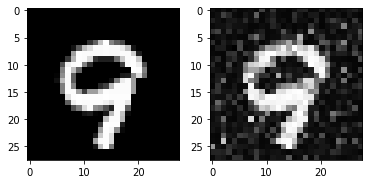

25  :  -0.8182145649712852 25
50  :  -0.8060965909047738 25
75  :  -0.7915551947026234 25
100  :  -0.7223972713238043 25
125  :  -0.7529370052043245 25
150  :  -0.7012241275101889 25
175  :  -0.6584190782965815 25
200  :  -0.3085010492844461 25
225  :  -0.08990632882934099 25
250  :  -0.0730958205920477 25
275  :  0.1285497105383413 25
300  :  0.15677867710909776 25
325  :  0.16572559782983587 25
350  :  0.16559853525906798 25
375  :  0.18576007282503637 25
400  :  0.19143930260602993 25
425  :  0.22294463945283483 25
450  :  0.22240674152341988 25
475  :  0.22513584303634404 25
500  :  0.2357866150146799 25
525  :  0.24201181320752452 25
550  :  0.24899241778826875 25
575  :  0.24970615454442735 25
600  :  0.25170231164120316 25
625  :  0.2564393274290814 25
650  :  0.25647620400873683 25
675  :  0.25798750389464453 25
700  :  0.26114833921845415 25
725  :  0.2633762053107721 25
750  :  0.26706766785355096 25
775  :  0.26878060633696055 25
800  :  0.26878060633696055 25
825  :  0.2720

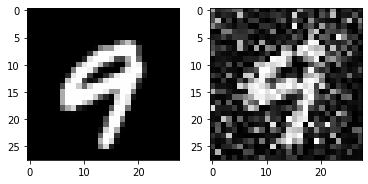

25  :  -0.8121976950065383 25
50  :  -0.7958201516817985 25
75  :  -0.8052893926430694 25
100  :  -0.7967682304586551 25
125  :  -0.7262980753769428 25
150  :  -0.4726015493265734 25
175  :  -0.43994307504615005 25
200  :  -0.28809728782723554 25
225  :  0.23613885117730982 25
250  :  0.2719594826979122 25
275  :  0.30379572911026304 25
300  :  0.3223318674381808 25
325  :  0.3223318674381808 25
350  :  0.3223318674381808 25
375  :  0.3223318674381808 25
400  :  0.3511444594559313 25
425  :  0.36248947213844335 25
450  :  0.36782286725546365 25
475  :  0.3782986161382118 25
500  :  0.3766076597588994 25
525  :  0.3826863633799336 25
550  :  0.39006400580677325 25
575  :  0.39140365198434923 25
600  :  0.39140365198434923 25
625  :  0.39140365198434923 25
650  :  0.39140365198434923 25
675  :  0.39486673856253895 25
700  :  0.40434115881969246 25
725  :  0.4047397722638169 25
750  :  0.40763452186843846 25
775  :  0.4120307501301734 25
800  :  0.4149820101726305 25
825  :  0.41498190976

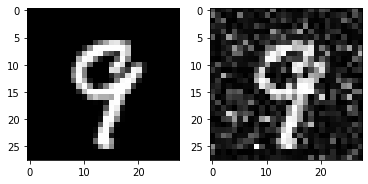

25  :  -0.6392592214752368 25
50  :  -0.6284784569341085 25
75  :  -0.20217159468751733 25
100  :  -0.04398241499442329 25
125  :  0.3308629802188461 25
150  :  0.3937418606933596 25
175  :  0.4283880727295084 25
200  :  0.4283880727295084 25
225  :  0.4283880727295084 25
250  :  0.44434376247190877 25
275  :  0.44434376247190877 25
300  :  0.4443827687051 25
325  :  0.4691779289684699 25
350  :  0.4703101496420483 25
375  :  0.4703101496420483 25
400  :  0.4709137913470639 25
425  :  0.4734336787732285 25
450  :  0.47723844834191786 25
475  :  0.4909865742618406 25
500  :  0.4909865742618406 25
525  :  0.49268102412304676 25
550  :  0.49936491607988664 25
575  :  0.49936491607988664 25
600  :  0.4998738361133257 25
625  :  0.5025551090755199 25
650  :  0.5062178484866628 25
675  :  0.5062491205417585 25
700  :  0.5091764709681369 25
725  :  0.5146290789859083 25
750  :  0.5146290789859083 25
775  :  0.5155089419316192 25
800  :  0.5164336815272691 25
825  :  0.5164573303008502 25
850 

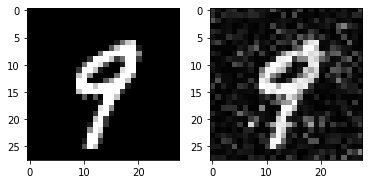

25  :  0.32128632303979 25
50  :  0.33879742360479226 25
75  :  0.29209376125193387 25
100  :  0.3195690077309751 25
125  :  0.30650678688652516 25
150  :  0.3220665800964061 25
175  :  0.34473968236134267 25
200  :  0.3429886790023268 25
225  :  0.36027543431617187 25
250  :  0.36238992375054807 25
275  :  0.3626358734055794 25
300  :  0.37292685604385534 25
325  :  0.37371610123496385 25
350  :  0.38627198362912146 25
375  :  0.39175205063058993 25
400  :  0.3934861604363146 25
425  :  0.39473939267468316 25
450  :  0.40512703357440427 25
475  :  0.40509313746976 25
500  :  0.4116140613136522 25
525  :  0.41741684984060623 25
550  :  0.4194772503517809 25
575  :  0.42176910176606675 25
600  :  0.42168242800028827 25
625  :  0.4240552399919753 25
650  :  0.42735776283878296 25
675  :  0.4281394840287176 25
700  :  0.42819790634170685 25
725  :  0.42940757048970185 25
750  :  0.4317884857519789 25
775  :  0.43246696735094736 25
800  :  0.43411374561355964 25
825  :  0.4349341276406979 

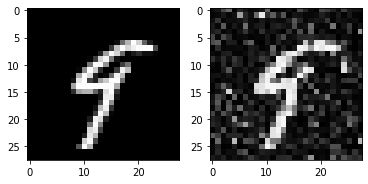

25  :  -0.8858918263183355 25
50  :  -0.8858918263183355 25
75  :  -0.8802397918371134 25
100  :  -0.8802397918371134 25
125  :  -0.8756251360956786 25
150  :  -0.8749501593116331 25
175  :  -0.8749626058769056 25
200  :  -0.8734747953959061 25
225  :  -0.8723357012308344 25
250  :  -0.8640184560105058 25
275  :  -0.8640184560105058 25
300  :  -0.8640184560105058 25
325  :  -0.8640184560105058 25
350  :  -0.8631376826442781 25
375  :  -0.8631376826442781 25
400  :  -0.8631376826442781 25
425  :  -0.8631376826442781 25
450  :  -0.8630822350029579 25
475  :  -0.8630822350029579 25
500  :  -0.862057256436491 25
525  :  -0.8618154788686196 25
550  :  -0.8617133817006168 25
575  :  -0.8606229889960018 25
600  :  -0.8606229889960018 25
625  :  -0.8600787004654893 25
650  :  -0.8600787004654893 25
675  :  -0.8600787004654893 25
700  :  -0.8598881456444497 25
725  :  -0.8594571949379212 25
750  :  -0.8591879392502384 25
775  :  -0.8591879392502384 25
800  :  -0.85883508829977 25
Time:  81.4153

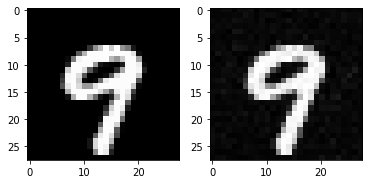

25  :  -0.7359853235970228 25
50  :  -0.655990375404615 25
75  :  -0.6308995484682037 25
100  :  -0.17258364106980423 25
125  :  0.08414209642313336 25
150  :  0.2500830885477936 25
175  :  0.3378984534341184 25
200  :  0.39528642637812783 25
225  :  0.3978708482176192 25
250  :  0.3978708482176192 25
275  :  0.40740130107034417 25
300  :  0.4094325513247073 25
325  :  0.42507303358754156 25
350  :  0.4246508798387478 25
375  :  0.42790113269691504 25
400  :  0.4320247387828764 25
425  :  0.44128196191123176 25
450  :  0.45232638420220045 25
475  :  0.4625814758409563 25
500  :  0.46283796186299514 25
525  :  0.46283796186299514 25
550  :  0.4687926313731273 25
575  :  0.4695092480864724 25
600  :  0.4745576659441994 25
625  :  0.47472814984059364 25
650  :  0.47472814984059364 25
675  :  0.4804786905227602 25
700  :  0.48132184712585 25
725  :  0.48202815711668195 25
750  :  0.4834617212309679 25
775  :  0.4834617212309679 25
800  :  0.48515237646956705 25
825  :  0.4901828419322919 2

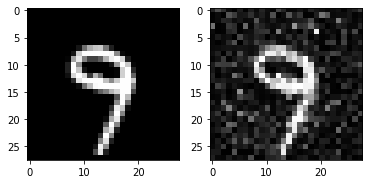

25  :  0.4892437607183019 25
50  :  0.4892437607183019 25
75  :  0.42805995505491534 25
100  :  0.43478971433113006 25
125  :  0.42060375817914936 25
150  :  0.4571045203889228 25
175  :  0.46425726722032606 25
200  :  0.4648996768189675 25
225  :  0.4709449928183467 25
250  :  0.47167035761218057 25
275  :  0.4834389724117765 25
300  :  0.49262986073050785 25
325  :  0.488974914767353 25
350  :  0.4895276620872894 25
375  :  0.5086805569435909 25
400  :  0.5087310193230911 25
425  :  0.5114647256526089 25
450  :  0.5177146690010993 25
475  :  0.5209846865923619 25
500  :  0.5228719622856051 25
525  :  0.522796449790639 25
550  :  0.5317009987359385 25
575  :  0.5310874058821811 25
600  :  0.5338860465322317 25
625  :  0.5338241737262758 25
650  :  0.5358146731004303 25
675  :  0.5357777188810948 25
700  :  0.5357777188810948 25
725  :  0.5396651744133616 25
750  :  0.5400902961860177 25
775  :  0.5410838897448619 25
800  :  0.5474316879860772 25
825  :  0.5474316879860772 25
850  :  0

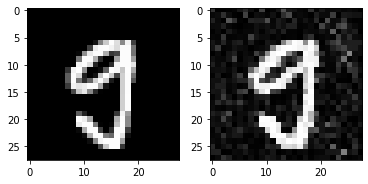

25  :  -0.8082529319647592 25
50  :  -0.8072696267317199 25
75  :  -0.792318003366669 25
100  :  -0.697034220276367 25
125  :  -0.48825207437190665 25
150  :  -0.21864665295208774 25
175  :  -0.11390808994051008 25
200  :  -0.06098002125049995 25
225  :  0.04114539193965466 25
250  :  0.04012835332667025 25
275  :  0.04773745398001167 25
300  :  0.1279336090194939 25
325  :  0.14107407245167092 25
350  :  0.1296838556671046 25
375  :  0.18612587666527614 25
400  :  0.3009335159898025 25
425  :  0.27965292215296694 25
450  :  0.27965292215296694 25
475  :  0.27965292215296694 25
500  :  0.27965292215296694 25
525  :  0.27965292215296694 25
550  :  0.2854842872416482 25
575  :  0.2927675196219246 25
600  :  0.29434812176359537 25
625  :  0.2983244363352912 25
650  :  0.2983244363352912 25
675  :  0.2983244363352912 25
700  :  0.2983244363352912 25
725  :  0.30964462858923675 25
750  :  0.320738200139491 25
775  :  0.320738200139491 25
800  :  0.320738200139491 25
825  :  0.32480632581021

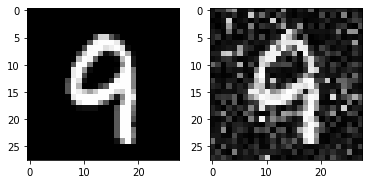

25  :  -0.5467313664642618 25
50  :  -0.22449794906043208 25
75  :  -0.7407324100381099 25
100  :  -0.673786986181538 25
125  :  -0.6839645932434556 25
150  :  -0.677232442791637 25
175  :  -0.614229955049548 25
200  :  -0.6045883684817057 25
225  :  -0.5782291446666172 25
250  :  -0.5575375761629994 25
275  :  -0.4307225112740579 25
300  :  -0.3185987214859992 25
325  :  -0.16042999231320437 25
350  :  0.002519129341855997 25
375  :  0.024754817119272132 25
400  :  0.1212869052547525 25
425  :  0.20541684859495768 25
450  :  0.1954768830227337 25
475  :  0.1954768830227337 25
500  :  0.1954768830227337 25
525  :  0.27157498050464285 25
550  :  0.2786392359599828 25
575  :  0.3195052083042993 25
600  :  0.35787876506389776 25
625  :  0.35789527927334563 25
650  :  0.3699199437408158 25
675  :  0.3713447469129555 25
700  :  0.3741775226285517 25
725  :  0.39125654717223707 25
750  :  0.39125654717223707 25
775  :  0.40587862774413425 25
800  :  0.41217812971079104 25
825  :  0.416952253

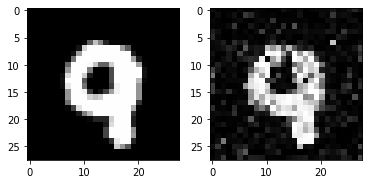

In [9]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28*28) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_rbf_mnist_seed1', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [11]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

252.50452518463135
72.91168665885925
123.23640547290681
31.669777552371027


In [12]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

2287
800
1162.420634920635
286.053617828219


In [13]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

29.3053062492563
10.896515235990536
19.344308358641563
6.483421193376489
